# Initial

In [1]:
# %% #### Imports ####
import pandas as pd
import seaborn as sns
import json
from HSSL import *
from scipy.cluster.hierarchy import cophenet
from benchmark.results import load_all_results

/mnt/large_storage/cabi/hnsw_searchers/HSSL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
            is_efficient[i] = True
    return is_efficient

In [3]:
def get_pareto_frontier(df, x, y, split):
    # removes all rows that don't lie on the pareto frontier
    to_plot = df.sort_values(x, ascending=True).reset_index(drop=True)
    d = {} # store last x values
    drop_list = []
    for algo in set(df[split]):
        d[algo] = 0
    for i in range(len(to_plot)):
        x_ = to_plot.iloc[i][x]
        y_ = to_plot.iloc[i][y]
        algo = to_plot.iloc[i][split]
        if y_ > d[algo]:
            d[algo] = y_
        else:
            drop_list.append(i)
    to_plot.drop(drop_list, inplace=True)
        
    return to_plot

# Quality Measurements

## Quality Measurements ALOI hssl

In [ ]:
## -- aloi-hssl -- ##
import time
import itertools

dataset = 'aloi733-111k'

ef = [5, 11, 22, 47, 100]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

combinations = list(itertools.product(ef, mbhs, lmd))

data = []


for f in load_all_results(dataset, ""):
    try:
        if f.attrs['algo'] != 'scipy': continue
        gt_dendro = f["dendrogram"][:]
        gt_dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in gt_dendro]
        start = time.time()
        gt_coph_dists = cophenet(gt_dendro)
        end = time.time()
        t = end - start
        print(f"gt_coph_dist took: {t}s")
    finally:
        f.close()

indices = np.random.choice(gt_coph_dists.shape[0], size=10_000_000, replace=False)

temp = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWhssl": continue
    params = json.loads(f.attrs["params"])
    print(f.filename + "ratio_data.npz")
    
    if (params['ef'], 
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]

        start = time.time()
        coph_dists = cophenet(dendro)
        end = time.time()
        t = end - start
        print(f"coph_dist took: {t}s")

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = coph_dists[indices]

        mask1 = sampled_gt_coph_dists != 0
        sampled_gt_coph_dists = sampled_gt_coph_dists[mask1]
        sampled_coph_dists = sampled_coph_dists[mask1]
        mask2 = sampled_coph_dists != 0
        sampled_gt_coph_dists = sampled_gt_coph_dists[mask2]
        sampled_coph_dists = sampled_coph_dists[mask2]

        # temp += 1
        # if temp <= 10:
        #     plt.figure(figsize=(6, 4))
        #     sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
        #     plt.title(f"Cophenetic distances ef={params['ef']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
        #     plt.xlabel("Ground Truth Cophenetic Distances")
        #     plt.ylabel("Sampled Cophenetic Distances")
        #     plt.grid(True)
        #     plt.tight_layout()
        #     plt.show()

        start = time.time()
        # for x, y in zip(sampled_coph_dists, sampled_gt_coph_dists):
        #     if x==0 or y==0:
        #         print("0 error encountered")
        ratio = [x / y for x, y in zip(sampled_coph_dists, sampled_gt_coph_dists)]
        # print(ratio[0:20])
        mean_ratio = np.exp(np.mean(np.abs(np.log(ratio))))
        print(mean_ratio)
        end = time.time()
        t = end - start
        print(f"mean_ratio took: {t}s")
        
        ### --- Save data to make histogram later --- ###
        np.savez_compressed("ratio_data.npz", ratio=ratio, mean_ratio=mean_ratio)

        plt.figure(figsize=(8, 5))
        plt.hist(ratio, bins=1000, edgecolor="black", alpha=0.7)
        plt.axvline(mean_ratio, color="red", linestyle="--", linewidth=2, label=f"Mean Ratio = {mean_ratio:.3f}")
        plt.xlabel("Ratio values")
        plt.ylabel("Frequency")
        plt.title("Histogram of Ratio Values")
        plt.legend()
        plt.show()
        ### ------------------------------------------ ###

        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "run": f.attrs['run'],
        "mean_ratio": mean_ratio, 
        })
    finally:
        f.close()

df_ALOIhssl = pd.DataFrame(data=data)
df_ALOIhssl.head(5)

11_71_19 ratio_data.npz
47_42_51 ratio_data.npz
22_42_14 ratio_data.npz
5_200_10 ratio_data.npz
100_71_10 ratio_data.npz
11_119_14 ratio_data.npz
11_119_19 ratio_data.npz
47_42_100 ratio_data.npz
47_71_10 ratio_data.npz
47_42_14 ratio_data.npz
47_25_100 ratio_data.npz
47_71_51 ratio_data.npz
100_25_37 ratio_data.npz
47_119_100 ratio_data.npz
100_25_51 ratio_data.npz
11_42_26 ratio_data.npz
22_119_51 ratio_data.npz
47_42_26 ratio_data.npz
11_42_72 ratio_data.npz
5_25_72 ratio_data.npz
100_42_100 ratio_data.npz
11_119_10 ratio_data.npz
100_119_51 ratio_data.npz
100_200_100 ratio_data.npz
5_71_10 ratio_data.npz
5_200_19 ratio_data.npz
22_200_26 ratio_data.npz
47_200_14 ratio_data.npz
22_25_14 ratio_data.npz
22_25_72 ratio_data.npz
47_25_37 ratio_data.npz
22_71_72 ratio_data.npz
22_71_51 ratio_data.npz
47_25_51 ratio_data.npz
11_71_72 ratio_data.npz
100_119_100 ratio_data.npz
100_119_19 ratio_data.npz
11_200_100 ratio_data.npz
100_119_72 ratio_data.npz
100_119_37 ratio_data.npz
5_119_19 ra

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
df_ALOIhssl_averages = df_ALOIhssl.groupby(["algo", "params"], as_index=False).mean()
df_ALOIhssl_averages

algo                                             params         time  \
0   HNSWhssl  {"ef": 100, "params": {"higher_max_degree": 13...  1457.008485   
1   HNSWhssl  {"ef": 100, "params": {"higher_max_degree": 13...  1436.381032   
2   HNSWhssl  {"ef": 100, "params": {"higher_max_degree": 13...  1341.432544   
3   HNSWhssl  {"ef": 100, "params": {"higher_max_degree": 13...  1280.695080   
4   HNSWhssl  {"ef": 100, "params": {"higher_max_degree": 13...  1428.671045   
..       ...                                                ...          ...   
95  HNSWhssl  {"ef": 5, "params": {"higher_max_degree": 7, "...   126.550399   
96  HNSWhssl  {"ef": 5, "params": {"higher_max_degree": 7, "...   118.661449   
97  HNSWhssl  {"ef": 5, "params": {"higher_max_degree": 7, "...   108.757996   
98  HNSWhssl  {"ef": 5, "params": {"higher_max_degree": 7, "...   116.306643   
99  HNSWhssl  {"ef": 5, "params": {"higher_max_degree": 7, "...   109.287573   

           n       run  mean_ratio  
0   110249.0  3.000000    1.294283  
1   110249.0  3.000000    1.327875  
2   110249.0  3.000000    1.202103  
3   110249.0  3.000000    1.472724  
4   110249.0  3.000000    1.376203  
..       ...       ...         ...  
95  110249.0  3.000000    1.537020  
96  110249.0  3.000000    1.469870  
97  110249.0  2.666667    1.896438  
98  110249.0  3.000000    1.703093  
99  110249.0  1.500000    1.634022  

[100 rows x 6 columns]

In [6]:
df_ALOIhssl_split = df_ALOIhssl_averages
df_ALOIhssl_split["params_dict"] = df_ALOIhssl_split["params"].apply(lambda x: json.loads(x))
df_ef = df_ALOIhssl_split["params_dict"].apply(lambda d: d.get("ef")).rename("ef").to_frame()
df_params = df_ALOIhssl_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_ALOIhssl_split = pd.concat([df_ALOIhssl_split, df_ef[['ef']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_ALOIhssl_split

algo                                             params         time  \
0   HNSWhssl  {"ef": 100, "params": {"higher_max_degree": 13...  1457.008485   
1   HNSWhssl  {"ef": 100, "params": {"higher_max_degree": 13...  1436.381032   
2   HNSWhssl  {"ef": 100, "params": {"higher_max_degree": 13...  1341.432544   
3   HNSWhssl  {"ef": 100, "params": {"higher_max_degree": 13...  1280.695080   
4   HNSWhssl  {"ef": 100, "params": {"higher_max_degree": 13...  1428.671045   
..       ...                                                ...          ...   
95  HNSWhssl  {"ef": 5, "params": {"higher_max_degree": 7, "...   126.550399   
96  HNSWhssl  {"ef": 5, "params": {"higher_max_degree": 7, "...   118.661449   
97  HNSWhssl  {"ef": 5, "params": {"higher_max_degree": 7, "...   108.757996   
98  HNSWhssl  {"ef": 5, "params": {"higher_max_degree": 7, "...   116.306643   
99  HNSWhssl  {"ef": 5, "params": {"higher_max_degree": 7, "...   109.287573   

           n       run  mean_ratio  \
0   110249.0  3.000000    1.294283   
1   110249.0  3.000000    1.327875   
2   110249.0  3.000000    1.202103   
3   110249.0  3.000000    1.472724   
4   110249.0  3.000000    1.376203   
..       ...       ...         ...   
95  110249.0  3.000000    1.537020   
96  110249.0  3.000000    1.469870   
97  110249.0  2.666667    1.896438   
98  110249.0  3.000000    1.703093   
99  110249.0  1.500000    1.634022   

                                          params_dict   ef  lowest_max_degree  \
0   {'ef': 100, 'params': {'higher_max_degree': 13...  100                 26   
1   {'ef': 100, 'params': {'higher_max_degree': 13...  100                 26   
2   {'ef': 100, 'params': {'higher_max_degree': 13...  100                 26   
3   {'ef': 100, 'params': {'higher_max_degree': 13...  100                 26   
4   {'ef': 100, 'params': {'higher_max_degree': 13...  100                 26   
..                                                ...  ...                ...   
95  {'ef': 5, 'params': {'higher_max_degree': 7, '...    5                 14   
96  {'ef': 5, 'params': {'higher_max_degree': 7, '...    5                 14   
97  {'ef': 5, 'params': {'higher_max_degree': 7, '...    5                 14   
98  {'ef': 5, 'params': {'higher_max_degree': 7, '...    5                 14   
99  {'ef': 5, 'params': {'higher_max_degree': 7, '...    5                 14   

    max_build_heap_size  
0                   119  
1                   200  
2                    25  
3                    42  
4                    71  
..                  ...  
95                  119  
96                  200  
97                   25  
98                   42  
99                   71  

[100 rows x 10 columns]

In [7]:
df_ALOIhssl_split.to_csv('ALOIhssl_meanRatio_average.csv', index=False)

In [8]:
df_ALOIhssl_split = df_ALOIhssl_split[["algo", "time", "mean_ratio", "ef", "max_build_heap_size", "lowest_max_degree"]]

pareto_aloihssl = get_pareto_frontier(df_ALOIhssl_split, "time", "mean_ratio", "algo")

pareto_aloihssl[["time", "mean_ratio", "ef", "max_build_heap_size", "lowest_max_degree"]]

time  mean_ratio  ef  max_build_heap_size  lowest_max_degree
0  108.757996    1.896438   5                   25                 14
5  134.775455    1.899342  11                   25                 14

In [9]:
filtered_df = pareto_aloihssl[pareto_aloihssl["mean_ratio"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "mean_ratio", "ef", "max_build_heap_size", "lowest_max_degree"]]

time  mean_ratio  ef  max_build_heap_size  lowest_max_degree
0  108.757996    1.896438   5                   25                 14

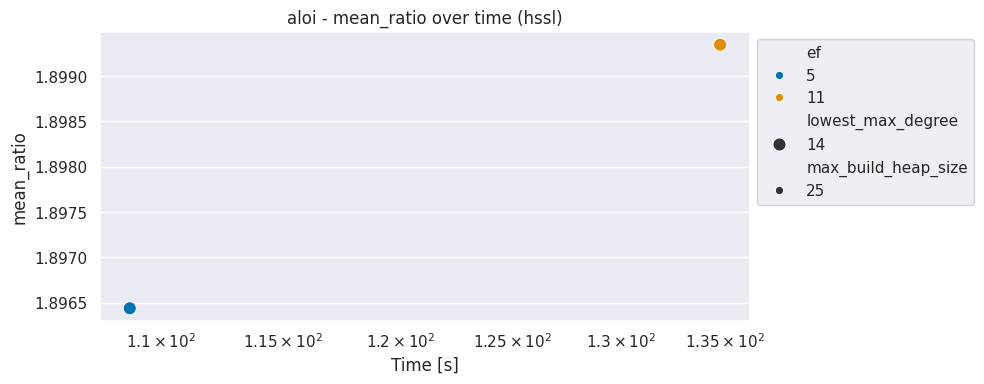

In [10]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_aloihssl, x="time", y="mean_ratio", 
                hue="ef",
                style="max_build_heap_size", 
                size="lowest_max_degree", 
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"aloi - mean_ratio over time (hssl)")
plt.xlabel("Time [s]")
plt.ylabel("mean_ratio")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

## Quality Measurements ALOI Kruskal

{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 5, 'lowest_max_degree': 10, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 42, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_frontier_size': None, 'level_norm_param_override'

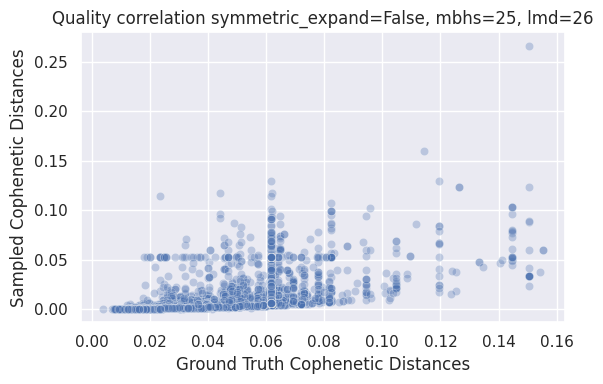

16.328634470220344
mean_ratio took: 2.0658950805664062s
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 50, 'lowest_max_degree': 100, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 5, 'lowest_max_degree': 10, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 9, 'lowest_max_degree': 19, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_

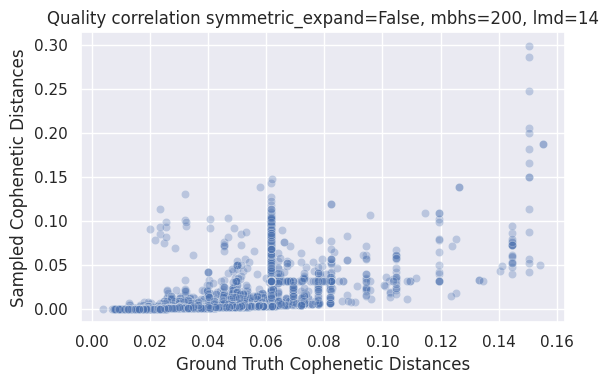

14.638874685154128
mean_ratio took: 2.0701870918273926s
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 18, 'lowest_max_degree': 37, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 36, 'lowest_max_degree': 72, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 18, 'lowest_max_degree': 37, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 42, 'ma

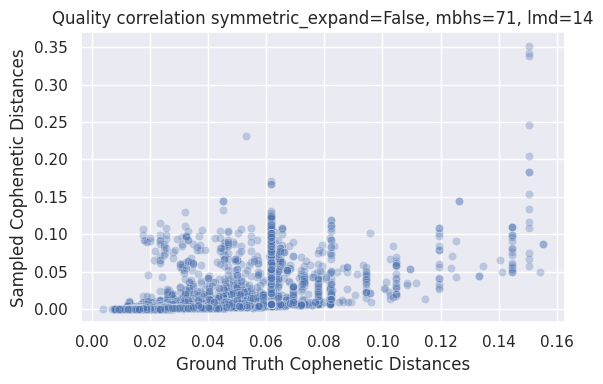

12.75009657162011
mean_ratio took: 2.066270112991333s
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 25, 'lowest_max_degree': 51, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
110248
coph_dist took: 97.17079877853394s


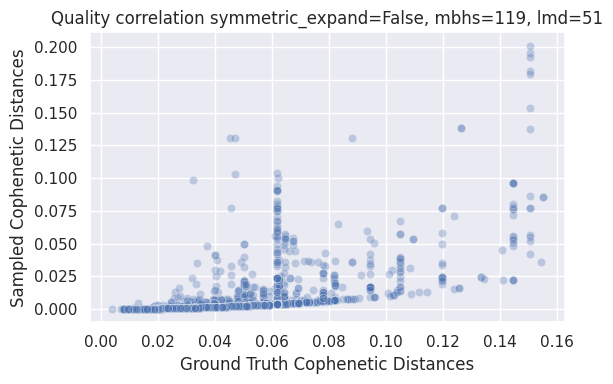

26.897051429386075
mean_ratio took: 2.076115369796753s
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 9, 'lowest_max_degree': 19, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 42, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
110248
coph_dist took: 96.55608654022217s


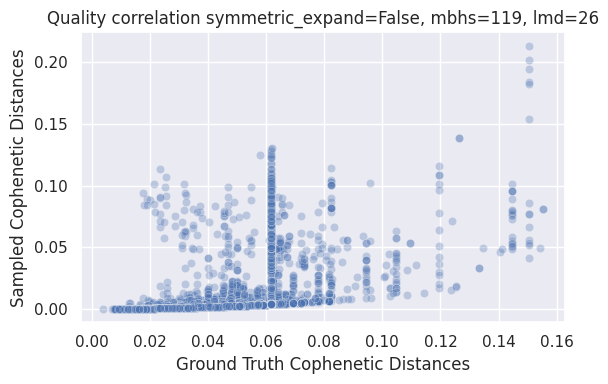

19.28137502877689
mean_ratio took: 2.0673694610595703s
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 7, 'lowest_max_degree': 14, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 36, 'lowest_max_degree': 72, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 25, 'lowest_max_degree': 51, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_b

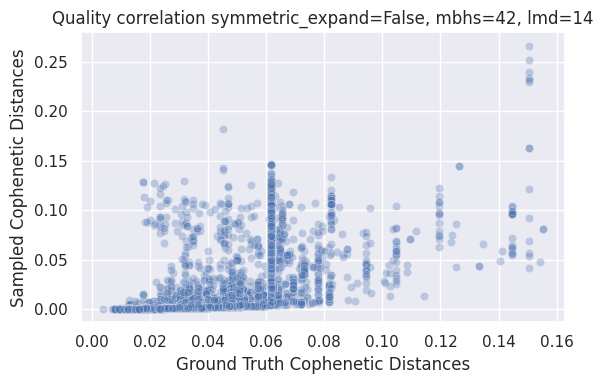

10.158059276588256
mean_ratio took: 2.0722005367279053s
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 42, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
110248
coph_dist took: 95.10941576957703s


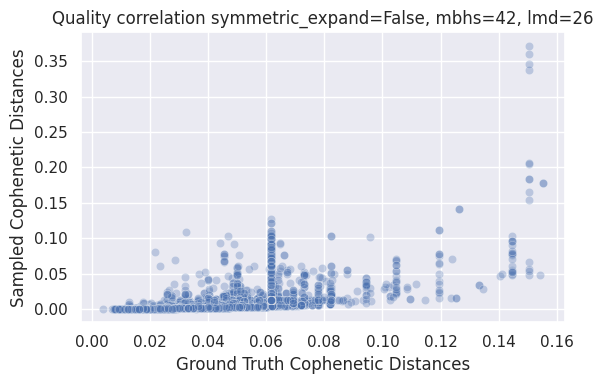

17.12228301240276
mean_ratio took: 2.0645956993103027s
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 7, 'lowest_max_degree': 14, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
110248
coph_dist took: 94.83511710166931s


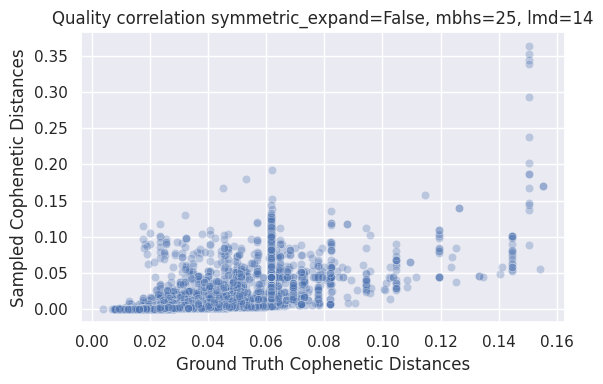

8.504088248785612
mean_ratio took: 2.066364288330078s
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 25, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 9, 'lowest_max_degree': 19, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 9, 'lowest_max_degree': 19, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 200, 'max_b

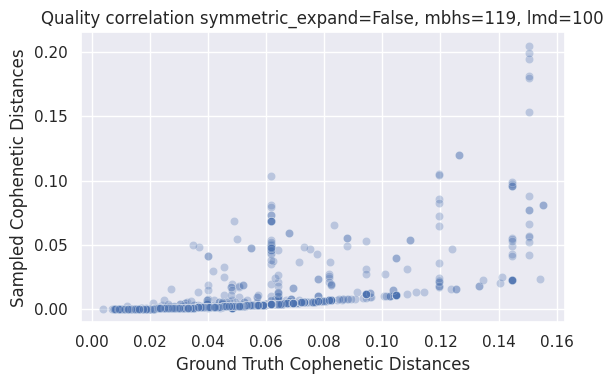

28.2963237209368
mean_ratio took: 2.067645788192749s
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 50, 'lowest_max_degree': 100, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 5, 'lowest_max_degree': 10, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 5, 'lowest_max_degree': 10, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_b

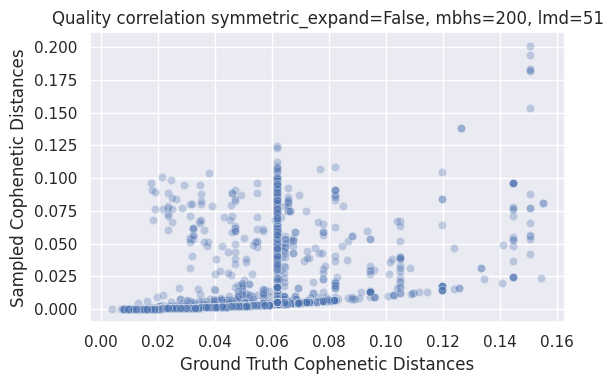

21.6108001129022
mean_ratio took: 2.0641472339630127s
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 36, 'lowest_max_degree': 72, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': True, 'params': {'higher_max_degree': 50, 'lowest_max_degree': 100, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 119, 'max_build_frontier_size': None, 'level_norm_param_override': None, 'insert_heuristic': False, 'insert_heuristic_extend': False, 'post_prune_heuristic': False, 'insert_minibatch_size': None, 'n_rounds': 1}}
{'minPts': 1, 'symmetric_expand': False, 'params': {'higher_max_degree': 13, 'lowest_max_degree': 26, 'max_layers': None, 'n_parallel_burnin': 1000, 'max_build_heap_size': 71, 'ma

algo       time       n  \
0  HNSWkruskal  19.420121  110249   
1  HNSWkruskal  23.280951  110249   
2  HNSWkruskal  23.283683  110249   
3  HNSWkruskal  28.181555  110249   
4  HNSWkruskal  19.119945  110249   

                                              params  run  mean_ratio  
0  {"minPts": 1, "symmetric_expand": false, "para...    3   16.328634  
1  {"minPts": 1, "symmetric_expand": false, "para...    3   14.638875  
2  {"minPts": 1, "symmetric_expand": false, "para...    3   12.750097  
3  {"minPts": 1, "symmetric_expand": false, "para...    3   26.897051  
4  {"minPts": 1, "symmetric_expand": false, "para...    3   19.281375

In [ ]:
## -- aloi-kruskal -- ##
import time
import itertools

se = [False]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

# Generate all combinations
combinations = list(itertools.product(se, mbhs, lmd))

data = []


temp = 0
error_count = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWkruskal": continue
    params = json.loads(f.attrs["params"])
    
    if (params['symmetric_expand'],
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        print(len(dendro))

        try:
            start = time.time()
            coph_dists = cophenet(dendro)
            end = time.time()
            t = end - start
            print(f"coph_dist took: {t}s")
        except:
            print("ERROR in cophenet")
            error_count += 1

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = np.sqrt(coph_dists[indices])

        mask1 = sampled_gt_coph_dists != 0
        sampled_gt_coph_dists = sampled_gt_coph_dists[mask1]
        sampled_coph_dists = sampled_coph_dists[mask1]
        mask2 = sampled_coph_dists != 0
        sampled_gt_coph_dists = sampled_gt_coph_dists[mask2]
        sampled_coph_dists = sampled_coph_dists[mask2]

        # temp += 1
        # if temp <= 10:
        #     plt.figure(figsize=(6, 4))
        #     sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
        #     plt.title(f"Quality correlation symmetric_expand={params['symmetric_expand']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
        #     plt.xlabel("Ground Truth Cophenetic Distances")
        #     plt.ylabel("Sampled Cophenetic Distances")
        #     plt.grid(True)
        #     plt.tight_layout()
        #     plt.show()

        start = time.time()
        ratio = [x / y for x, y in zip(sampled_coph_dists, sampled_gt_coph_dists)]
        mean_ratio = np.exp(np.mean(np.abs(np.log(ratio))))
        print(mean_ratio)
        end = time.time()
        t = end - start
        print(f"mean_ratio took: {t}s")

        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "run": f.attrs['run'],
        "mean_ratio": mean_ratio,
        })
    finally:
        f.close()

print(error_count)
df_ALOIkruskal = pd.DataFrame(data=data)
df_ALOIkruskal.head(5)

In [14]:
df_ALOIkruskal_averages = df_ALOIkruskal.groupby(["algo", "params"], as_index=False).mean()
df_ALOIkruskal_averages

algo                                             params       time  \
0   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  27.453903   
1   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  28.413875   
2   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  27.037048   
3   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  27.374050   
4   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  26.943251   
5   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  40.885921   
6   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  41.281878   
7   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  36.698203   
8   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  40.037981   
9   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  40.592578   
10  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  64.093311   
11  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  64.025795   
12  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  42.911019   
13  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  51.700931   
14  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  61.286025   
15  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  26.599249   
16  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  27.361269   
17  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  24.913825   
18  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  25.616951   
19  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  26.238796   

           n  run  mean_ratio  
0   110249.0  3.0   19.794931  
1   110249.0  3.0   20.603500  
2   110248.8  3.0   21.661263  
3   110249.0  3.0   17.503415  
4   110249.0  3.0   18.045900  
5   110249.0  3.0   24.992017  
6   110249.0  3.0   25.259729  
7   110249.0  3.0   27.934620  
8   110249.0  3.0   28.396146  
9   110248.8  3.0   20.697504  
10  110249.0  3.0   28.165738  
11  110249.0  3.0   28.401955  
12  110249.0  3.0   28.899534  
13  110249.0  3.0   28.998197  
14  110249.0  3.0   29.018437  
15  110249.0  3.0   16.600488  
16  110249.0  3.0   16.906373  
17  110249.0  3.0   13.664685  
18  110249.0  3.0   13.632317  
19  110249.0  3.0   16.199536

In [15]:
df_ALOIkruskal_split = df_ALOIkruskal_averages
df_ALOIkruskal_split["params_dict"] = df_ALOIkruskal_split["params"].apply(lambda x: json.loads(x))
df_ef = df_ALOIkruskal_split["params_dict"].apply(lambda d: d.get("symmetric_expand")).rename("symmetric_expand").to_frame()
df_params = df_ALOIkruskal_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_ALOIkruskal_split = pd.concat([df_ALOIkruskal_split, df_ef[['symmetric_expand']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_ALOIkruskal_split

algo                                             params       time  \
0   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  27.453903   
1   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  28.413875   
2   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  27.037048   
3   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  27.374050   
4   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  26.943251   
5   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  40.885921   
6   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  41.281878   
7   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  36.698203   
8   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  40.037981   
9   HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  40.592578   
10  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  64.093311   
11  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  64.025795   
12  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  42.911019   
13  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  51.700931   
14  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  61.286025   
15  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  26.599249   
16  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  27.361269   
17  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  24.913825   
18  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  25.616951   
19  HNSWkruskal  {"minPts": 1, "symmetric_expand": false, "para...  26.238796   

           n  run  mean_ratio  \
0   110249.0  3.0   19.794931   
1   110249.0  3.0   20.603500   
2   110248.8  3.0   21.661263   
3   110249.0  3.0   17.503415   
4   110249.0  3.0   18.045900   
5   110249.0  3.0   24.992017   
6   110249.0  3.0   25.259729   
7   110249.0  3.0   27.934620   
8   110249.0  3.0   28.396146   
9   110248.8  3.0   20.697504   
10  110249.0  3.0   28.165738   
11  110249.0  3.0   28.401955   
12  110249.0  3.0   28.899534   
13  110249.0  3.0   28.998197   
14  110249.0  3.0   29.018437   
15  110249.0  3.0   16.600488   
16  110249.0  3.0   16.906373   
17  110249.0  3.0   13.664685   
18  110249.0  3.0   13.632317   
19  110249.0  3.0   16.199536   

                                          params_dict  symmetric_expand  \
0   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
1   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
2   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
3   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
4   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
5   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
6   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
7   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
8   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
9   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
10  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
11  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
12  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
13  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
14  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
15  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
16  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
17  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
18  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
19  {'minPts': 1, 'symmetric_expand': False, 'para...             False   

    lowest_max_degree  max_build_heap_s

In [16]:
df_ALOIkruskal_split.to_csv('ALOIkruskal_meanRatio_average.csv', index=False)

In [17]:
df_ALOIkruskal_split = df_ALOIkruskal_split[["algo", "time", "mean_ratio", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

pareto_aloikruskal = get_pareto_frontier(df_ALOIkruskal_split, "time", "mean_ratio", "algo")

pareto_aloikruskal[["time", "mean_ratio", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  mean_ratio  symmetric_expand  max_build_heap_size  \
0   24.913825   13.664685             False                   25   
2   26.238796   16.199536             False                   71   
3   26.599249   16.600488             False                  119   
4   26.943251   18.045900             False                   71   
5   27.037048   21.661263             False                   25   
10  36.698203   27.934620             False                   25   
11  40.037981   28.396146             False                   42   
15  42.911019   28.899534             False                   25   
16  51.700931   28.998197             False                   42   
17  61.286025   29.018437             False                   71   

    lowest_max_degree  
0                  14  
2                  14  
3                  14  
4                  26  
5                  26  
10                 51  
11                 51  
15                100  
16                100  
17                100

In [18]:
filtered_df = pareto_aloikruskal[pareto_aloikruskal["mean_ratio"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "mean_ratio", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  mean_ratio  symmetric_expand  max_build_heap_size  \
0  24.913825   13.664685             False                   25   

   lowest_max_degree  
0                 14

In [19]:
pareto_aloikruskal = pareto_aloikruskal[["time", "mean_ratio", "max_build_heap_size", "lowest_max_degree"]]

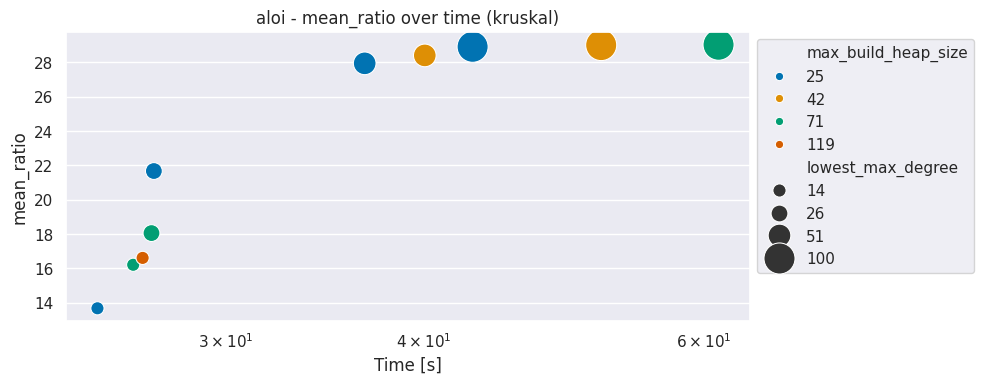

In [20]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_aloikruskal, x="time", y="mean_ratio", 
                hue="max_build_heap_size",
                size="lowest_max_degree",
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"aloi - mean_ratio over time (kruskal)")
plt.xlabel("Time [s]")
plt.ylabel("mean_ratio")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

## Quality Measurements ALOI MST

coph_dist took: 98.55565285682678s


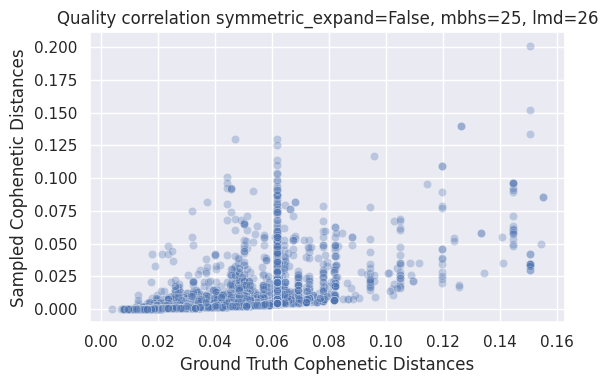

18.24524409226505
mean_ratio took: 2.078254461288452s
coph_dist took: 96.85883331298828s


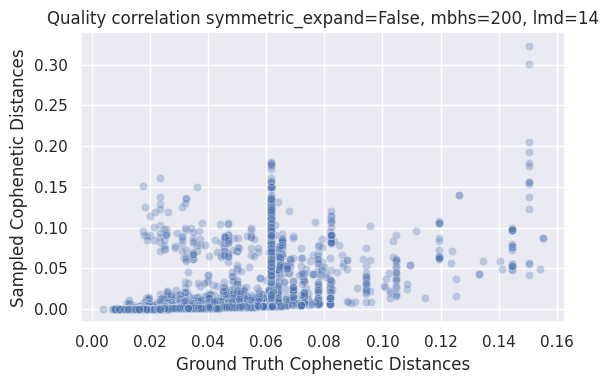

13.075215002879647
mean_ratio took: 2.081913709640503s
coph_dist took: 97.50946259498596s


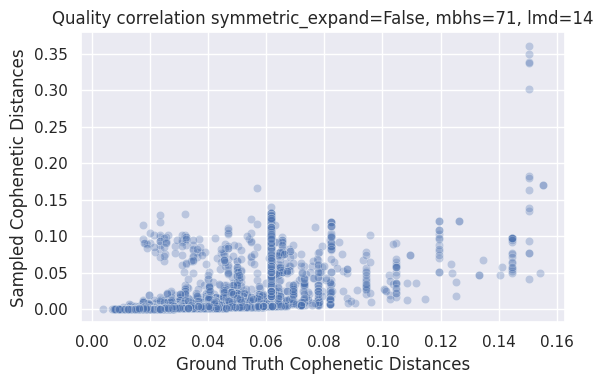

11.376876848179055
mean_ratio took: 2.086894989013672s
coph_dist took: 99.2414321899414s


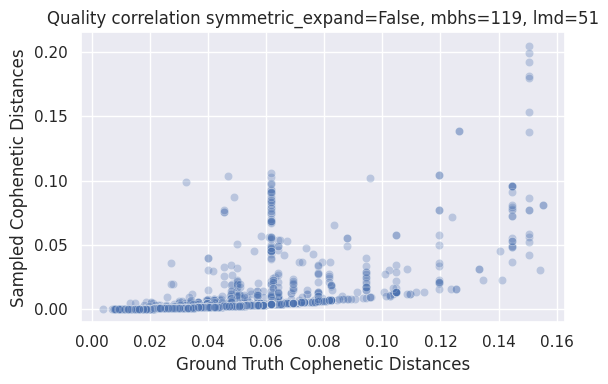

26.84401093117453
mean_ratio took: 2.072434902191162s
coph_dist took: 96.94956731796265s


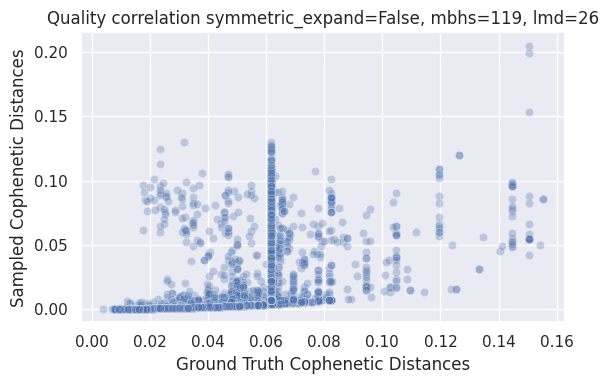

16.626571962631743
mean_ratio took: 2.07283353805542s
coph_dist took: 96.62551236152649s


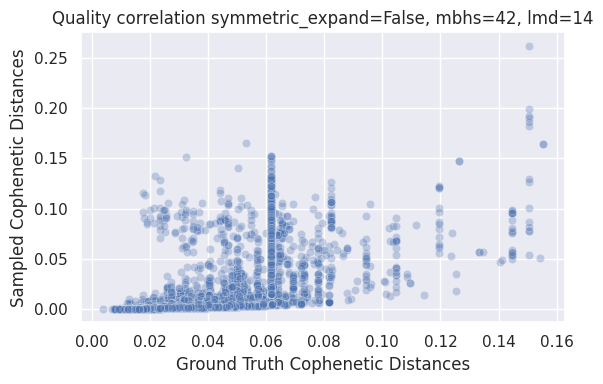

10.288413754010255
mean_ratio took: 2.107577323913574s
coph_dist took: 98.98543691635132s


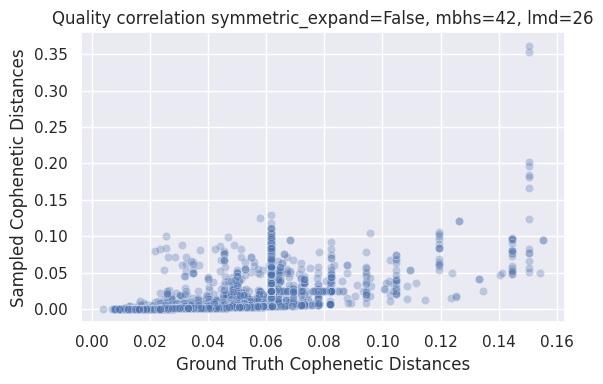

15.130910935630457
mean_ratio took: 2.071500778198242s
coph_dist took: 98.6050112247467s


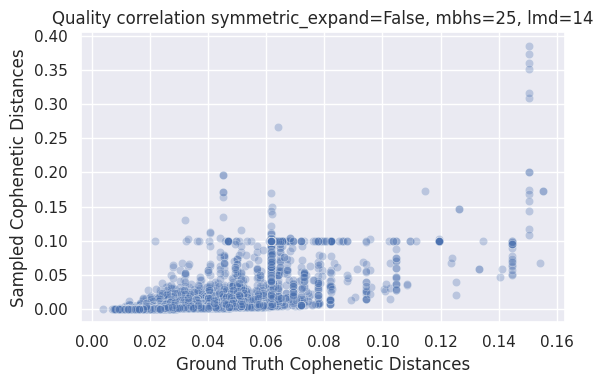

8.713586192311151
mean_ratio took: 2.070107936859131s
coph_dist took: 99.62721467018127s


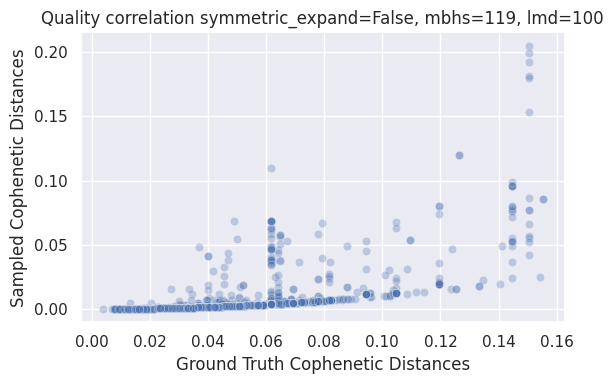

28.06737562836426
mean_ratio took: 2.073150157928467s
coph_dist took: 99.50836277008057s


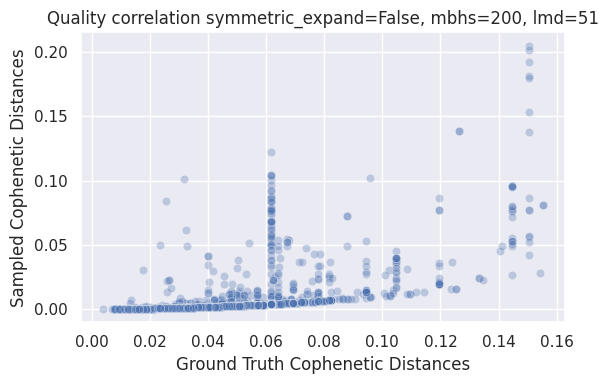

27.49541317645025
mean_ratio took: 2.153089761734009s
coph_dist took: 97.08283710479736s
14.682386029614715
mean_ratio took: 2.0735340118408203s
coph_dist took: 97.13664388656616s
20.136506150663518
mean_ratio took: 2.072629928588867s
coph_dist took: 99.6123719215393s
29.092448940550884
mean_ratio took: 2.0743887424468994s
coph_dist took: 99.64263415336609s
29.12272101392485
mean_ratio took: 2.068991184234619s
coph_dist took: 99.50376796722412s
28.48742615973759
mean_ratio took: 2.0767674446105957s
coph_dist took: 97.60757803916931s
12.73412341113325
mean_ratio took: 2.0697901248931885s
coph_dist took: 97.85476875305176s
16.506048559305793
mean_ratio took: 2.0762078762054443s
coph_dist took: 99.41949486732483s
28.782698384555733
mean_ratio took: 2.0684313774108887s
coph_dist took: 99.3175356388092s
28.475668211729822
mean_ratio took: 2.0725066661834717s
coph_dist took: 99.45367360115051s
28.22588504531222
mean_ratio took: 2.0714783668518066s
coph_dist took: 99.89551639556885s
15.952499

algo      time       n  \
0  HNSWmst  1.462382  110249   
1  HNSWmst  1.274887  110249   
2  HNSWmst  1.100214  110249   
3  HNSWmst  2.850373  110249   
4  HNSWmst  1.483659  110249   

                                              params  run  mean_ratio  
0  {"minPts": 1, "symmetric_expand": false, "para...    3   18.245244  
1  {"minPts": 1, "symmetric_expand": false, "para...    3   13.075215  
2  {"minPts": 1, "symmetric_expand": false, "para...    3   11.376877  
3  {"minPts": 1, "symmetric_expand": false, "para...    3   26.844011  
4  {"minPts": 1, "symmetric_expand": false, "para...    3   16.626572

In [ ]:
## -- aloi-mst -- ##
import time
import itertools

se = [False]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

# Generate all combinations
combinations = list(itertools.product(se, mbhs, lmd))

data = []


temp = 0
error_count = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWmst": continue
    params = json.loads(f.attrs["params"])
    
    if (params['symmetric_expand'],
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]

        try:
            start = time.time()
            coph_dists = cophenet(dendro)
            end = time.time()
            t = end - start
            print(f"coph_dist took: {t}s")
        except:
            print("ERROR in cophenet")
            error_count += 1

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = np.sqrt(coph_dists[indices])

        mask1 = sampled_gt_coph_dists != 0
        sampled_gt_coph_dists = sampled_gt_coph_dists[mask1]
        sampled_coph_dists = sampled_coph_dists[mask1]
        mask2 = sampled_coph_dists != 0
        sampled_gt_coph_dists = sampled_gt_coph_dists[mask2]
        sampled_coph_dists = sampled_coph_dists[mask2]

        # temp += 1
        # if temp <= 10:
        #     plt.figure(figsize=(6, 4))
        #     sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
        #     plt.title(f"Quality correlation symmetric_expand={params['symmetric_expand']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
        #     plt.xlabel("Ground Truth Cophenetic Distances")
        #     plt.ylabel("Sampled Cophenetic Distances")
        #     plt.grid(True)
        #     plt.tight_layout()
        #     plt.show()

        start = time.time()
        ratio = [x / y for x, y in zip(sampled_coph_dists, sampled_gt_coph_dists)]
        mean_ratio = np.exp(np.mean(np.abs(np.log(ratio))))
        print(mean_ratio)
        end = time.time()
        t = end - start
        print(f"mean_ratio took: {t}s")

        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "run": f.attrs['run'],
        "mean_ratio": mean_ratio,
        })
    finally:
        f.close()

print(error_count)
df_ALOImst = pd.DataFrame(data=data)
df_ALOImst.head(5)

In [22]:
df_ALOImst_averages = df_ALOImst.groupby(["algo", "params"], as_index=False).mean()
df_ALOImst_averages

algo                                             params       time  \
0   HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   4.764069   
1   HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   5.961202   
2   HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   4.413289   
3   HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   4.531058   
4   HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   5.258257   
5   HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   8.331175   
6   HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   9.394511   
7   HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   5.722769   
8   HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   7.278926   
9   HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   7.905396   
10  HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...  14.984391   
11  HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...  16.431478   
12  HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   6.061126   
13  HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   9.661251   
14  HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...  12.343646   
15  HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   3.538279   
16  HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   4.184460   
17  HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   2.721887   
18  HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   2.794358   
19  HNSWmst  {"minPts": 1, "symmetric_expand": false, "para...   3.287822   

           n  run  mean_ratio  
0   110249.0  3.0   19.572422  
1   110249.0  3.0   19.281365  
2   110248.8  3.0   20.944884  
3   110249.0  3.0   16.604969  
4   110249.0  3.0   17.390656  
5   110249.0  3.0   23.019906  
6   110249.0  3.0   25.444483  
7   110249.0  3.0   28.068858  
8   110249.0  3.0   27.340742  
9   110249.0  3.0   22.921018  
10  110249.0  3.0   27.872637  
11  110249.0  3.0   28.184672  
12  110249.0  3.0   28.082848  
13  110249.0  3.0   28.636060  
14  110249.0  3.0   28.670013  
15  110249.0  3.0   15.565139  
16  110249.0  3.0   15.970298  
17  110249.0  3.0   12.253944  
18  110249.0  3.0   14.029578  
19  110249.0  3.0   14.380864

In [23]:
df_ALOImst_split = df_ALOImst
df_ALOImst_split["params_dict"] = df_ALOImst_split["params"].apply(lambda x: json.loads(x))
df_ef = df_ALOImst_split["params_dict"].apply(lambda d: d.get("symmetric_expand")).rename("symmetric_expand").to_frame()
df_params = df_ALOImst_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_ALOImst_split = pd.concat([df_ALOImst_split, df_ef[['symmetric_expand']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_ALOImst_split

algo       time       n  \
0   HNSWmst   1.462382  110249   
1   HNSWmst   1.274887  110249   
2   HNSWmst   1.100214  110249   
3   HNSWmst   2.850373  110249   
4   HNSWmst   1.483659  110249   
..      ...        ...     ...   
95  HNSWmst  12.712683  110249   
96  HNSWmst  22.047250  110249   
97  HNSWmst  22.103294  110249   
98  HNSWmst  21.555146  110249   
99  HNSWmst  27.301179  110249   

                                               params  run  mean_ratio  \
0   {"minPts": 1, "symmetric_expand": false, "para...    3   18.245244   
1   {"minPts": 1, "symmetric_expand": false, "para...    3   13.075215   
2   {"minPts": 1, "symmetric_expand": false, "para...    3   11.376877   
3   {"minPts": 1, "symmetric_expand": false, "para...    3   26.844011   
4   {"minPts": 1, "symmetric_expand": false, "para...    3   16.626572   
..                                                ...  ...         ...   
95  {"minPts": 1, "symmetric_expand": false, "para...    5   26.884088   
96  {"minPts": 1, "symmetric_expand": false, "para...    5   26.884088   
97  {"minPts": 1, "symmetric_expand": false, "para...    5   26.884088   
98  {"minPts": 1, "symmetric_expand": false, "para...    5   26.884088   
99  {"minPts": 1, "symmetric_expand": false, "para...    5   26.884088   

                                          params_dict  symmetric_expand  \
0   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
1   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
2   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
3   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
4   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
..                                                ...               ...   
95  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
96  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
97  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
98  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
99  {'minPts': 1, 'symmetric_expand': False, 'para...             False   

    lowest_max_degree  max_build_heap_size  
0                  26                   25  
1                  14                  200  
2                  14                   71  
3                  51                  119  
4                  26                  119  
..                ...                  ...  
95                 14                  119  
96                 26                  200  
97                100                   25  
98                 51                   25  
99                 51                   42  

[100 rows x 10 columns]

In [24]:
df_ALOImst_split.to_csv('ALOImst_meanRatio_average.csv', index=False)

In [25]:
df_ALOImst_split = df_ALOImst_split[["algo", "time", "mean_ratio", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

pareto_aloimst = get_pareto_frontier(df_ALOImst_split, "time", "mean_ratio", "algo")

pareto_aloimst[["time", "mean_ratio", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  mean_ratio  symmetric_expand  max_build_heap_size  \
0   0.928769   10.288414             False                   42   
1   0.973973   10.615084             False                   71   
8   1.021972   13.632762             False                   42   
17  1.275457   13.904875             False                  119   
18  1.312192   28.028031             False                   25   
34  1.665019   28.272867             False                   25   
37  1.773061   28.475668             False                   25   
41  1.866875   28.482025             False                   25   
44  1.999383   28.782698             False                   25   
45  2.095636   28.876346             False                   25   
61  3.026754   29.066644             False                   42   
65  3.166528   29.092449             False                   42   
68  4.430801   29.136593             False                   71   

    lowest_max_degree  
0                  14  
1                  14  
8                  14  
17                 14  
18                 26  
34                 51  
37                 51  
41                 51  
44                100  
45                100  
61                100  
65                100  
68                100

In [26]:
filtered_df = pareto_aloimst[pareto_aloimst["mean_ratio"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "mean_ratio", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  mean_ratio  symmetric_expand  max_build_heap_size  \
0  0.928769   10.288414             False                   42   

   lowest_max_degree  
0                 14

In [27]:
pareto_aloimst = pareto_aloimst[["time", "mean_ratio", "max_build_heap_size", "lowest_max_degree"]]

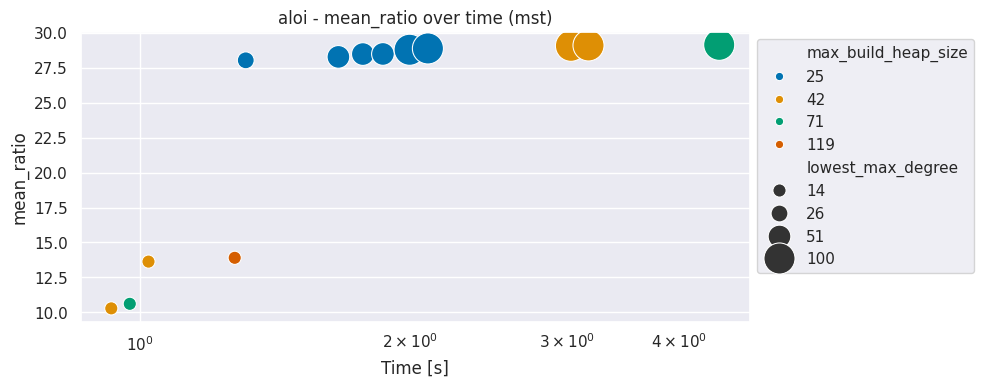

In [28]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_aloimst, x="time", y="mean_ratio", 
                hue="max_build_heap_size",
                size="lowest_max_degree",
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"aloi - mean_ratio over time (mst)")
plt.xlabel("Time [s]")
plt.ylabel("mean_ratio")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

## Quality Measurements MNIST hssl

gt_coph_dist took: 38.81595063209534s
coph_dist took: 38.19238066673279s


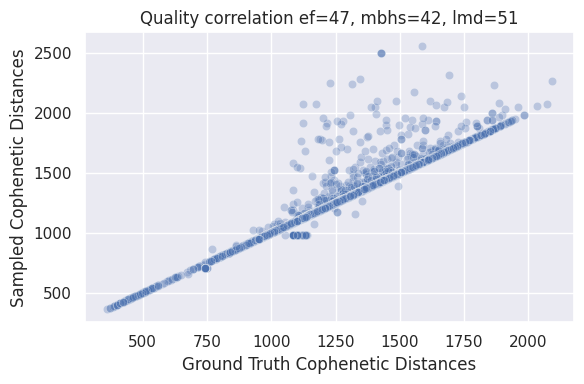

1.0055655572407156
mean_ratio took: 2.0852291584014893s
coph_dist took: 38.4058997631073s


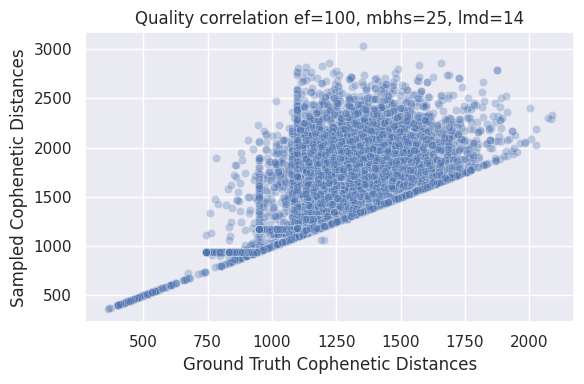

1.1828101863598837
mean_ratio took: 2.125537872314453s
coph_dist took: 38.39560675621033s


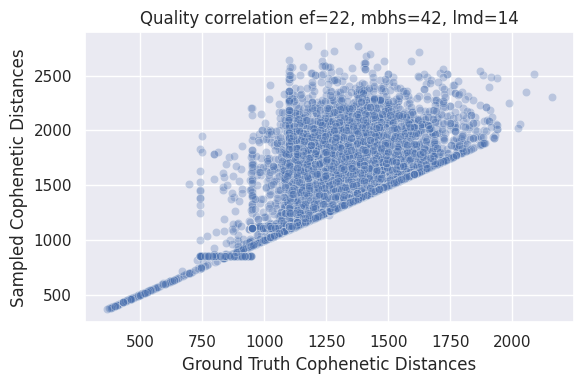

1.1244799953156477
mean_ratio took: 2.106119394302368s
coph_dist took: 38.330326318740845s


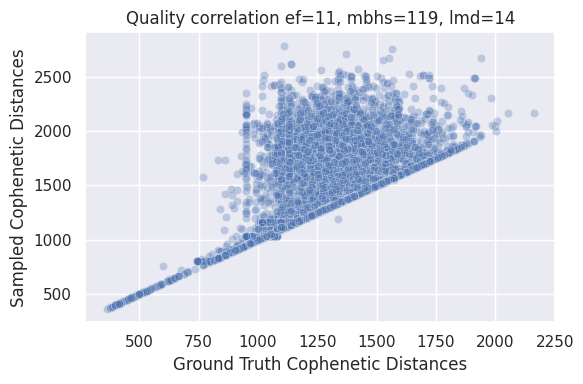

1.1161940735669862
mean_ratio took: 2.171948194503784s
coph_dist took: 37.98295593261719s


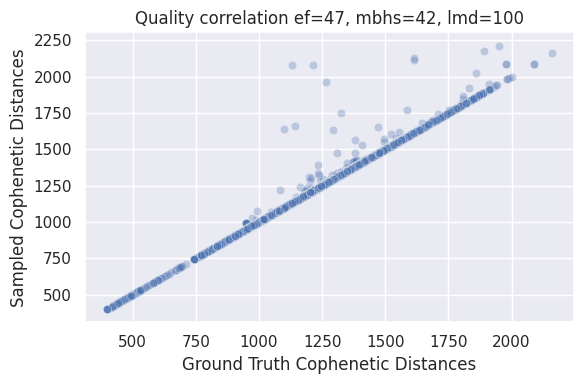

1.0006140224167914
mean_ratio took: 2.1123950481414795s
coph_dist took: 38.06826686859131s


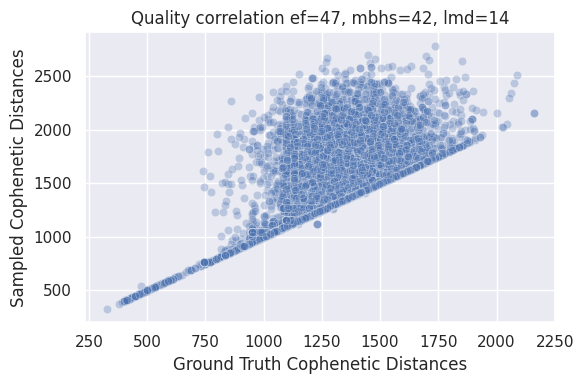

1.1166904615431255
mean_ratio took: 2.1043248176574707s
coph_dist took: 38.03010845184326s


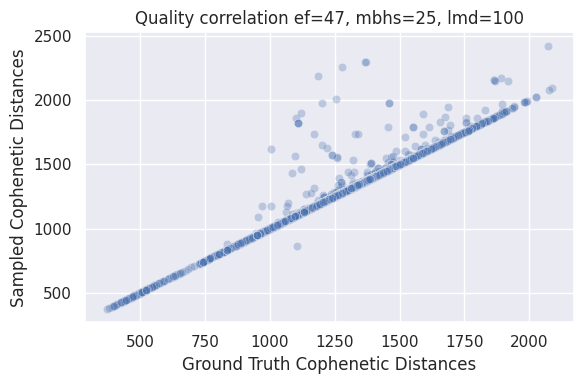

1.0016989996802952
mean_ratio took: 2.0821807384490967s
coph_dist took: 38.124218463897705s


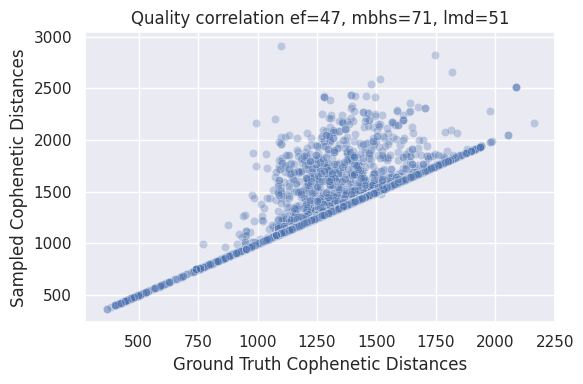

1.0185810090413703
mean_ratio took: 2.0715131759643555s
coph_dist took: 38.053866147994995s


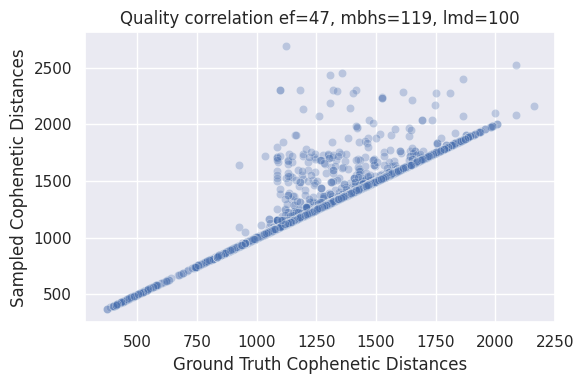

1.0056174887010212
mean_ratio took: 2.1084799766540527s
coph_dist took: 38.00091004371643s


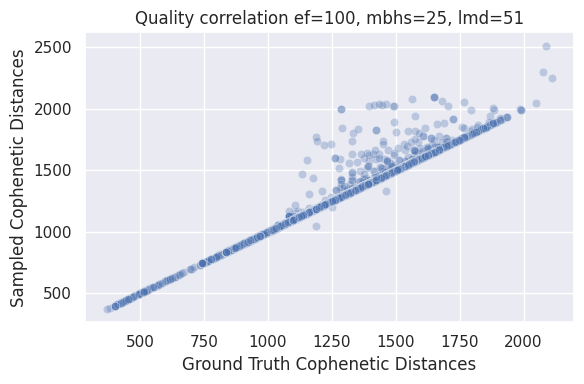

1.0023634432883495
mean_ratio took: 2.136359930038452s
coph_dist took: 38.26296591758728s
1.1711675541390467
mean_ratio took: 2.1049859523773193s
coph_dist took: 38.38779973983765s
1.0622032268551256
mean_ratio took: 2.089442014694214s
coph_dist took: 38.22184658050537s
1.0159029703566944
mean_ratio took: 2.211153030395508s
coph_dist took: 38.33783197402954s
1.0750823511958734
mean_ratio took: 2.0838356018066406s
coph_dist took: 38.025155544281006s
1.0005461409912586
mean_ratio took: 2.085817575454712s
coph_dist took: 38.36123752593994s
1.0859242552476434
mean_ratio took: 2.155367136001587s
coph_dist took: 37.99007201194763s
1.0191738682595572
mean_ratio took: 2.0723202228546143s
coph_dist took: 38.14142870903015s
1.0046802454022215
mean_ratio took: 2.0774383544921875s
coph_dist took: 38.444112062454224s
1.113662227886476
mean_ratio took: 2.1956560611724854s
coph_dist took: 38.40890693664551s
1.0838504804717555
mean_ratio took: 2.160722494125366s
coph_dist took: 38.07127046585083s
1.02

algo        time      n  \
0  HNSWhssl  804.777596  70000   
1  HNSWhssl  616.729362  70000   
2  HNSWhssl  179.858649  70000   
3  HNSWhssl  114.302616  70000   
4  HNSWhssl  983.602818  70000   

                                              params  mean_ratio  
0  {"ef": 47, "params": {"higher_max_degree": 25,...    1.005566  
1  {"ef": 100, "params": {"higher_max_degree": 7,...    1.182810  
2  {"ef": 22, "params": {"higher_max_degree": 7, ...    1.124480  
3  {"ef": 11, "params": {"higher_max_degree": 7, ...    1.116194  
4  {"ef": 47, "params": {"higher_max_degree": 50,...    1.000614

In [ ]:
## -- mnist-hssl -- ##
import time
import itertools

dataset = 'mnist-70k'

ef = [5, 11, 22, 47, 100]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

combinations = list(itertools.product(ef, mbhs, lmd))

data = []


for f in load_all_results(dataset, ""):
    try:
        if f.attrs['algo'] != 'scipy': continue
        gt_dendro = f["dendrogram"][:]
        gt_dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in gt_dendro]
        gt_dendro = elki_sort_dendrogram(gt_dendro)
        start = time.time()
        gt_coph_dists = cophenet(gt_dendro)
        end = time.time()
        t = end - start
        print(f"gt_coph_dist took: {t}s")
    finally:
        f.close()
indices = np.random.choice(gt_coph_dists.shape[0], size=10_000_000, replace=False)

temp = 0
error_count = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWhssl": continue
    params = json.loads(f.attrs["params"])
    
    if (params['ef'], 
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        dendro = elki_sort_dendrogram(dendro)

        try:
            start = time.time()
            coph_dists = cophenet(dendro)
            end = time.time()
            t = end - start
            print(f"coph_dist took: {t}s")
        except:
            print("ERROR in cophenet")
            error_count += 1

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = coph_dists[indices]

        mask1 = sampled_gt_coph_dists != 0
        sampled_gt_coph_dists = sampled_gt_coph_dists[mask1]
        sampled_coph_dists = sampled_coph_dists[mask1]
        mask2 = sampled_coph_dists != 0
        sampled_gt_coph_dists = sampled_gt_coph_dists[mask2]
        sampled_coph_dists = sampled_coph_dists[mask2]        

        temp += 1
        if temp <= 10:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
            plt.title(f"Quality correlation ef={params['ef']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
            plt.xlabel("Ground Truth Cophenetic Distances")
            plt.ylabel("Sampled Cophenetic Distances")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        start = time.time()
        ratio = [x / y for x, y in zip(sampled_coph_dists, sampled_gt_coph_dists)]
        mean_ratio = np.exp(np.mean(np.abs(np.log(ratio))))
        print(mean_ratio)
        end = time.time()
        t = end - start
        print(f"mean_ratio took: {t}s")


        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "mean_ratio": mean_ratio,
        })
    finally:
        f.close()

print(error_count)
df_MNISThssl = pd.DataFrame(data=data)
df_MNISThssl.head(5)

In [25]:
df_MNISThssl_split = df_MNISThssl
df_MNISThssl_split["params_dict"] = df_MNISThssl_split["params"].apply(lambda x: json.loads(x))
df_ef = df_MNISThssl_split["params_dict"].apply(lambda d: d.get("ef")).rename("ef").to_frame()
df_params = df_MNISThssl_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_MNISThssl_split = pd.concat([df_MNISThssl_split, df_ef[['ef']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_MNISThssl_split

algo         time      n  \
0   HNSWhssl   804.777596  70000   
1   HNSWhssl   616.729362  70000   
2   HNSWhssl   179.858649  70000   
3   HNSWhssl   114.302616  70000   
4   HNSWhssl   983.602818  70000   
..       ...          ...    ...   
95  HNSWhssl  1513.484621  70000   
96  HNSWhssl   198.429513  70000   
97  HNSWhssl   304.447488  70000   
98  HNSWhssl   720.778153  70000   
99  HNSWhssl   267.482976  70000   

                                               params  mean_ratio  \
0   {"ef": 47, "params": {"higher_max_degree": 25,...    1.005566   
1   {"ef": 100, "params": {"higher_max_degree": 7,...    1.182810   
2   {"ef": 22, "params": {"higher_max_degree": 7, ...    1.124480   
3   {"ef": 11, "params": {"higher_max_degree": 7, ...    1.116194   
4   {"ef": 47, "params": {"higher_max_degree": 50,...    1.000614   
..                                                ...         ...   
95  {"ef": 100, "params": {"higher_max_degree": 25...    1.010744   
96  {"ef": 22, "params": {"higher_max_degree": 7, ...    1.066543   
97  {"ef": 11, "params": {"higher_max_degree": 25,...    1.004073   
98  {"ef": 11, "params": {"higher_max_degree": 50,...    1.006949   
99  {"ef": 22, "params": {"higher_max_degree": 13,...    1.084339   

                                          params_dict   ef  lowest_max_degree  \
0   {'ef': 47, 'params': {'higher_max_degree': 25,...   47                 51   
1   {'ef': 100, 'params': {'higher_max_degree': 7,...  100                 14   
2   {'ef': 22, 'params': {'higher_max_degree': 7, ...   22                 14   
3   {'ef': 11, 'params': {'higher_max_degree': 7, ...   11                 14   
4   {'ef': 47, 'params': {'higher_max_degree': 50,...   47                100   
..                                                ...  ...                ...   
95  {'ef': 100, 'params': {'higher_max_degree': 25...  100                 51   
96  {'ef': 22, 'params': {'higher_max_degree': 7, ...   22                 14   
97  {'ef': 11, 'params': {'higher_max_degree': 25,...   11                 51   
98  {'ef': 11, 'params': {'higher_max_degree': 50,...   11                100   
99  {'ef': 22, 'params': {'higher_max_degree': 13,...   22                 26   

    max_build_heap_size  
0                    42  
1                    25  
2                    42  
3                   119  
4                    42  
..                  ...  
95                  200  
96                  200  
97                   25  
98                  119  
99                   42  

[100 rows x 9 columns]

In [26]:
df_MNISThssl_split.to_csv('MNISThssl_meanRatio.csv', index=False)

In [27]:
df_MNISThssl_split = df_MNISThssl_split[["algo", "time", "mean_ratio", "ef", "max_build_heap_size", "lowest_max_degree"]]

pareto_mnisthssl = get_pareto_frontier(df_MNISThssl_split, "time", "mean_ratio", "algo")

pareto_mnisthssl[["time", "mean_ratio", "ef", "max_build_heap_size", "lowest_max_degree"]]

time  mean_ratio  ef  max_build_heap_size  lowest_max_degree
0    82.380580    1.119312   5                   71                 14
1    84.365238    1.123846   5                  119                 14
3   101.771719    1.178013   5                   25                 14
13  166.991063    1.184518  22                   25                 14
18  180.665542    1.189977  22                  119                 14

In [28]:
filtered_df = pareto_mnisthssl[pareto_mnisthssl["mean_ratio"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "mean_ratio", "ef", "max_build_heap_size", "lowest_max_degree"]]

time  mean_ratio  ef  max_build_heap_size  lowest_max_degree
0  82.38058    1.119312   5                   71                 14

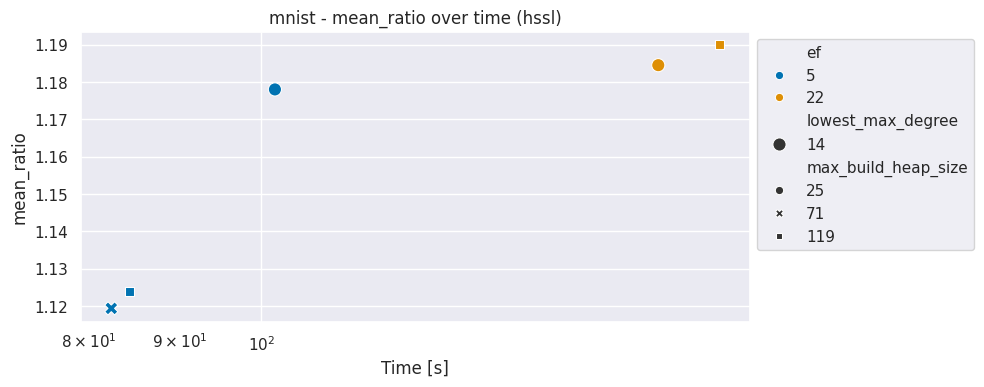

In [29]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_mnisthssl, x="time", y="mean_ratio", 
                hue="ef",
                style="max_build_heap_size", 
                size="lowest_max_degree", 
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"mnist - mean_ratio over time (hssl)")
plt.xlabel("Time [s]")
plt.ylabel("mean_ratio")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

## Quality Measurements MNIST Kruskal

coph_dist took: 38.45032358169556s


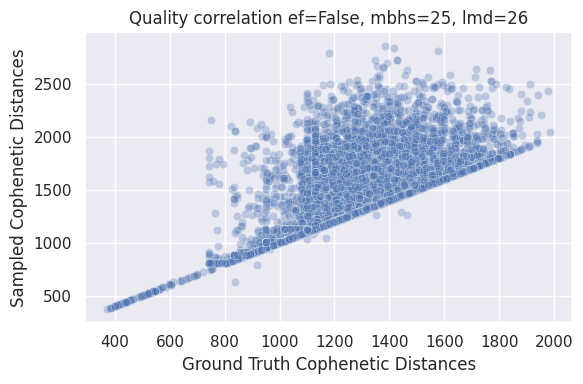

1.1020278741841565
mean_ratio took: 2.0251011848449707s
coph_dist took: 38.41565704345703s


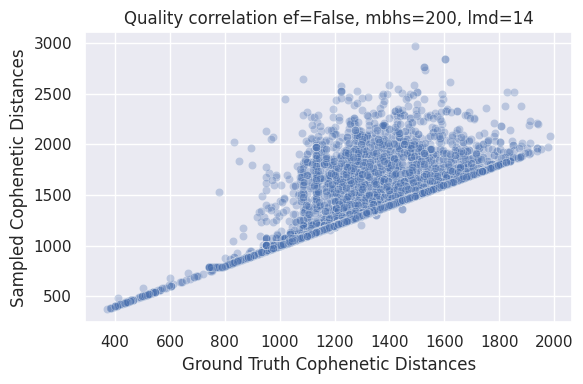

1.05483376705497
mean_ratio took: 2.0695528984069824s
coph_dist took: 38.73546028137207s


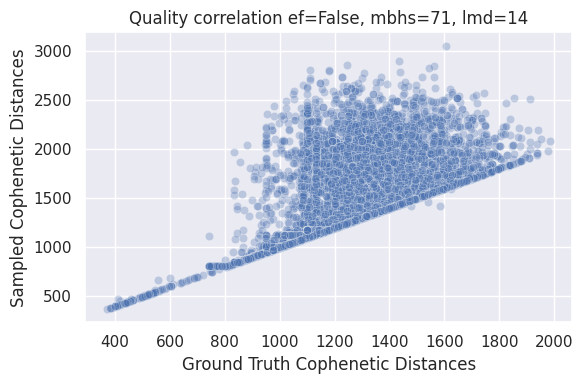

1.1347145240589156
mean_ratio took: 2.0656208992004395s
coph_dist took: 38.34313106536865s


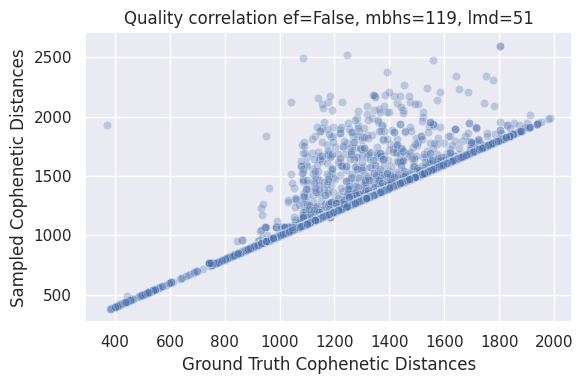

1.0126571924868857
mean_ratio took: 2.042024850845337s
coph_dist took: 38.530781745910645s


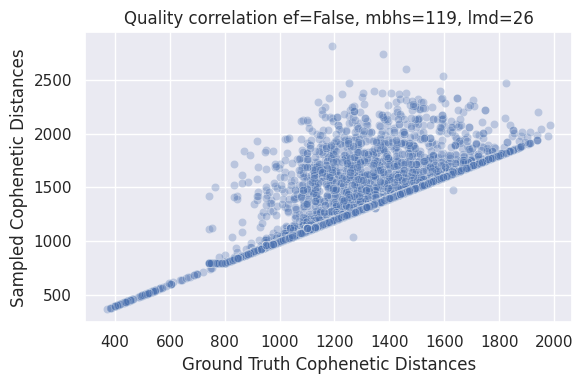

1.0376414547909538
mean_ratio took: 1.99135422706604s
coph_dist took: 42.32491493225098s


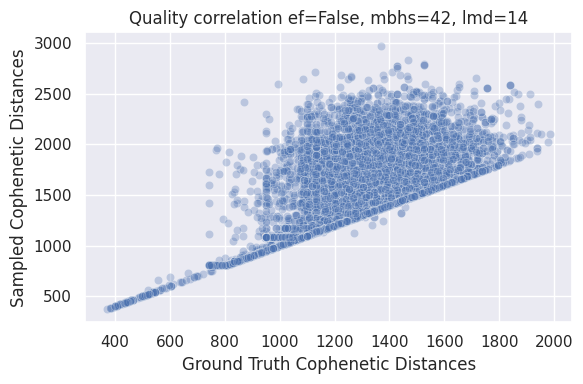

1.1576347602587598
mean_ratio took: 2.0869200229644775s
coph_dist took: 42.479514837265015s


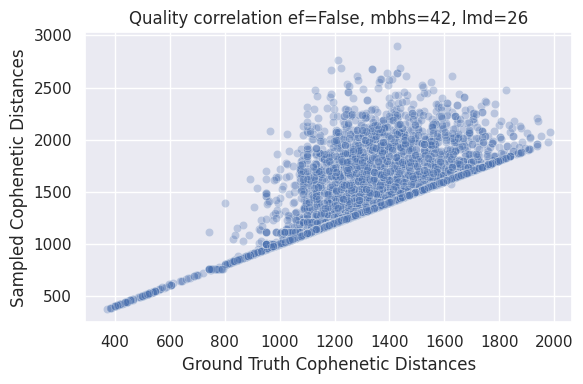

1.061448046584463
mean_ratio took: 2.0426111221313477s
coph_dist took: 42.55535936355591s


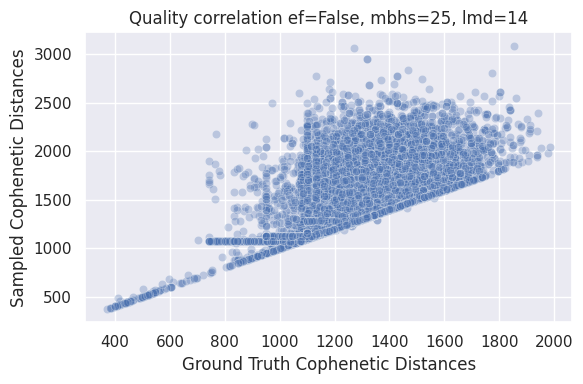

1.1562605616243786
mean_ratio took: 2.091082811355591s
coph_dist took: 42.171998262405396s


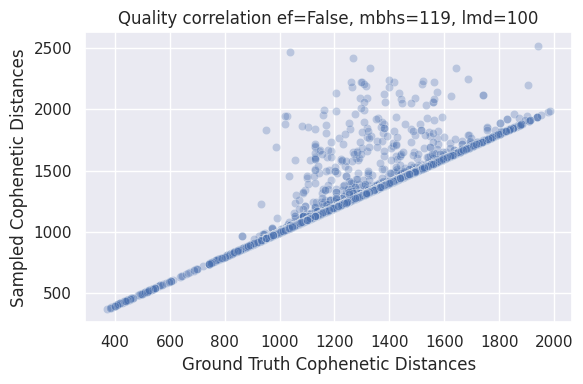

1.0082763207164915
mean_ratio took: 2.0609617233276367s
coph_dist took: 38.37743592262268s


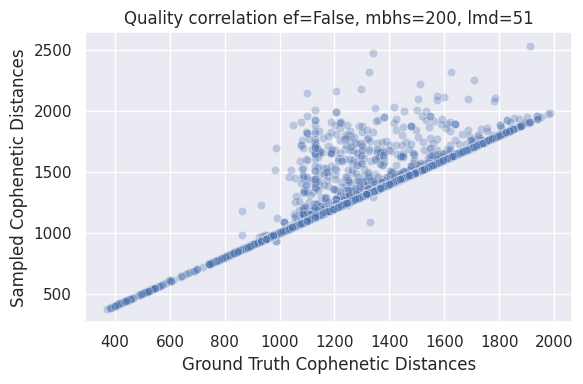

1.0099466767317764
mean_ratio took: 1.95186448097229s
coph_dist took: 38.687488079071045s
1.0979100403472557
mean_ratio took: 2.089512586593628s
coph_dist took: 38.33066153526306s
1.0217521283883277
mean_ratio took: 2.0502066612243652s
coph_dist took: 38.2995445728302s
1.0012513246420458
mean_ratio took: 2.0498719215393066s
coph_dist took: 38.4048011302948s
1.0012923312630944
mean_ratio took: 2.040482997894287s
coph_dist took: 38.42133021354675s
1.0057420341434984
mean_ratio took: 2.055427074432373s
coph_dist took: 38.491177797317505s
1.0757491344598569
mean_ratio took: 2.0680198669433594s
coph_dist took: 38.28714609146118s
1.020111168347852
mean_ratio took: 2.066058874130249s
coph_dist took: 45.070868253707886s
1.00252840893684
mean_ratio took: 2.036799430847168s
coph_dist took: 45.14989447593689s
1.0042028119822488
mean_ratio took: 2.0537710189819336s
coph_dist took: 38.36371898651123s
1.0071954971971973
mean_ratio took: 2.042961597442627s
0


algo       time      n  \
0  HNSWkruskal  15.554245  70000   
1  HNSWkruskal  16.572302  70000   
2  HNSWkruskal  15.253799  70000   
3  HNSWkruskal  23.377166  70000   
4  HNSWkruskal  15.705465  70000   

                                              params  mean_ratio  
0  {"minPts": 1, "symmetric_expand": false, "para...    1.102028  
1  {"minPts": 1, "symmetric_expand": false, "para...    1.054834  
2  {"minPts": 1, "symmetric_expand": false, "para...    1.134715  
3  {"minPts": 1, "symmetric_expand": false, "para...    1.012657  
4  {"minPts": 1, "symmetric_expand": false, "para...    1.037641

In [ ]:
## -- mnist-kruskal -- ##
import time
import itertools

se = [False]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

# Generate all combinations
combinations = list(itertools.product(se, mbhs, lmd))

data = []


temp = 0
error_count = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWkruskal": continue
    params = json.loads(f.attrs["params"])
    
    if (params['symmetric_expand'],
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        dendro = elki_sort_dendrogram(dendro)

        try:
            start = time.time()
            coph_dists = cophenet(dendro)
            end = time.time()
            t = end - start
            print(f"coph_dist took: {t}s")
        except:
            print("ERROR in cophenet")
            error_count += 1

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = np.sqrt(coph_dists[indices])

        mask1 = sampled_gt_coph_dists != 0
        sampled_gt_coph_dists = sampled_gt_coph_dists[mask1]
        sampled_coph_dists = sampled_coph_dists[mask1]
        mask2 = sampled_coph_dists != 0
        sampled_gt_coph_dists = sampled_gt_coph_dists[mask2]
        sampled_coph_dists = sampled_coph_dists[mask2]        

        temp += 1
        if temp <= 10:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
            plt.title(f"Quality correlation ef={params['symmetric_expand']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
            plt.xlabel("Ground Truth Cophenetic Distances")
            plt.ylabel("Sampled Cophenetic Distances")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        start = time.time()
        ratio = [x / y for x, y in zip(sampled_coph_dists, sampled_gt_coph_dists)]
        mean_ratio = np.exp(np.mean(np.abs(np.log(ratio))))
        print(mean_ratio)
        end = time.time()
        t = end - start
        print(f"mean_ratio took: {t}s")

        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "mean_ratio": mean_ratio,
        })
    finally:
        f.close()

print(error_count)
df_MNISTkruskal = pd.DataFrame(data=data)
df_MNISTkruskal.head(5)

In [31]:
df_MNISTkruskal_split = df_MNISTkruskal
df_MNISTkruskal_split["params_dict"] = df_MNISTkruskal_split["params"].apply(lambda x: json.loads(x))
df_ef = df_MNISTkruskal_split["params_dict"].apply(lambda d: d.get("symmetric_expand")).rename("symmetric_expand").to_frame()
df_params = df_MNISTkruskal_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_MNISTkruskal_split = pd.concat([df_MNISTkruskal_split, df_ef[['symmetric_expand']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_MNISTkruskal_split

algo       time      n  \
0   HNSWkruskal  15.554245  70000   
1   HNSWkruskal  16.572302  70000   
2   HNSWkruskal  15.253799  70000   
3   HNSWkruskal  23.377166  70000   
4   HNSWkruskal  15.705465  70000   
5   HNSWkruskal  17.661479  70000   
6   HNSWkruskal  14.391205  70000   
7   HNSWkruskal  16.918314  70000   
8   HNSWkruskal  33.872446  70000   
9   HNSWkruskal  25.552272  70000   
10  HNSWkruskal  14.974581  70000   
11  HNSWkruskal  21.577345  70000   
12  HNSWkruskal  27.754680  70000   
13  HNSWkruskal  33.217834  70000   
14  HNSWkruskal  33.386465  70000   
15  HNSWkruskal  16.113104  70000   
16  HNSWkruskal  17.429884  70000   
17  HNSWkruskal  23.621367  70000   
18  HNSWkruskal  21.729967  70000   
19  HNSWkruskal  22.835749  70000   

                                               params  mean_ratio  \
0   {"minPts": 1, "symmetric_expand": false, "para...    1.102028   
1   {"minPts": 1, "symmetric_expand": false, "para...    1.054834   
2   {"minPts": 1, "symmetric_expand": false, "para...    1.134715   
3   {"minPts": 1, "symmetric_expand": false, "para...    1.012657   
4   {"minPts": 1, "symmetric_expand": false, "para...    1.037641   
5   {"minPts": 1, "symmetric_expand": false, "para...    1.157635   
6   {"minPts": 1, "symmetric_expand": false, "para...    1.061448   
7   {"minPts": 1, "symmetric_expand": false, "para...    1.156261   
8   {"minPts": 1, "symmetric_expand": false, "para...    1.008276   
9   {"minPts": 1, "symmetric_expand": false, "para...    1.009947   
10  {"minPts": 1, "symmetric_expand": false, "para...    1.097910   
11  {"minPts": 1, "symmetric_expand": false, "para...    1.021752   
12  {"minPts": 1, "symmetric_expand": false, "para...    1.001251   
13  {"minPts": 1, "symmetric_expand": false, "para...    1.001292   
14  {"minPts": 1, "symmetric_expand": false, "para...    1.005742   
15  {"minPts": 1, "symmetric_expand": false, "para...    1.075749   
16  {"minPts": 1, "symmetric_expand": false, "para...    1.020111   
17  {"minPts": 1, "symmetric_expand": false, "para...    1.002528   
18  {"minPts": 1, "symmetric_expand": false, "para...    1.004203   
19  {"minPts": 1, "symmetric_expand": false, "para...    1.007195   

                                          params_dict  symmetric_expand  \
0   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
1   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
2   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
3   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
4   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
5   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
6   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
7   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
8   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
9   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
10  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
11  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
12  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
13  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
14  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
15  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
16  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
17  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
18  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
19  {'minPts': 1, 'symmetric_expand': False, 'para...             False   

    lowest_max_degree  max_build_heap_size  
0                  26                   25  
1                  14                  200  
2                  14                   71  
3                  51      

In [32]:
df_MNISTkruskal_split.to_csv('MNISTkruskal_meanRatio.csv', index=False)

In [33]:
df_MNISTkruskal_split = df_MNISTkruskal_split[["algo", "time", "mean_ratio", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

pareto_mnistkruskal = get_pareto_frontier(df_MNISTkruskal_split, "time", "mean_ratio", "algo")

pareto_mnistkruskal[["time", "mean_ratio", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  mean_ratio  symmetric_expand  max_build_heap_size  \
0  14.391205    1.061448             False                   42   
1  14.974581    1.097910             False                   71   
2  15.253799    1.134715             False                   71   
7  16.918314    1.156261             False                   25   
9  17.661479    1.157635             False                   42   

   lowest_max_degree  
0                 26  
1                 26  
2                 14  
7                 14  
9                 14

In [34]:
filtered_df = pareto_mnistkruskal[pareto_mnistkruskal["mean_ratio"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "mean_ratio", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  mean_ratio  symmetric_expand  max_build_heap_size  \
0  14.391205    1.061448             False                   42   

   lowest_max_degree  
0                 26

In [35]:
pareto_mnistkruskal = pareto_mnistkruskal[["time", "mean_ratio", "max_build_heap_size", "lowest_max_degree"]]

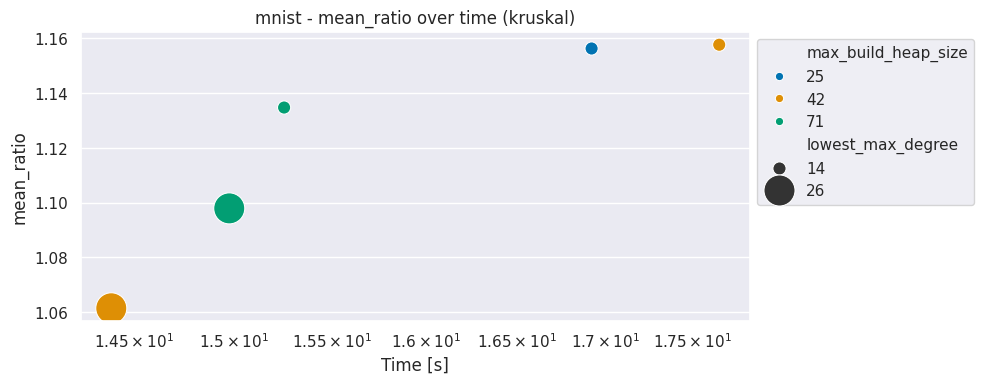

In [36]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_mnistkruskal, x="time", y="mean_ratio", 
                hue="max_build_heap_size",
                size="lowest_max_degree",
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"mnist - mean_ratio over time (kruskal)")
plt.xlabel("Time [s]")
plt.ylabel("mean_ratio")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

## Quality Measurements MNIST MST

coph_dist took: 38.408695936203s


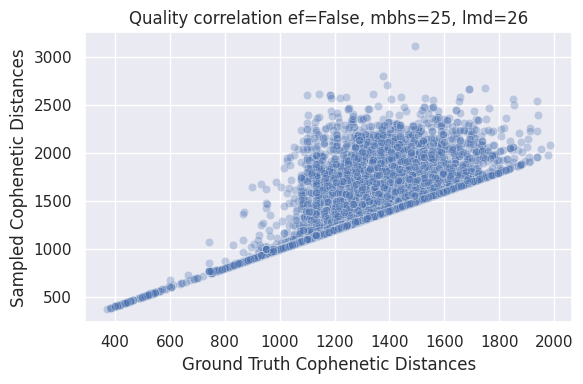

1.0800879794355158
mean_ratio took: 2.086649179458618s
coph_dist took: 38.55090570449829s


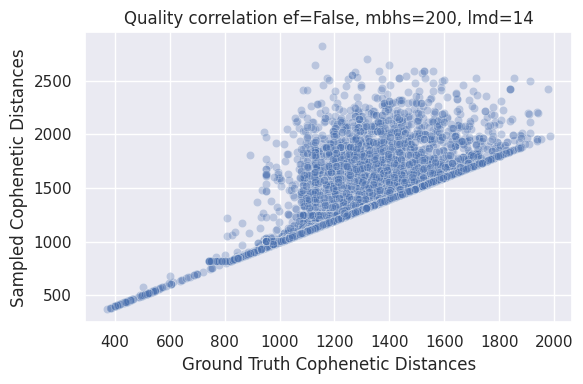

1.0628871048239514
mean_ratio took: 2.054710865020752s
coph_dist took: 38.77546739578247s


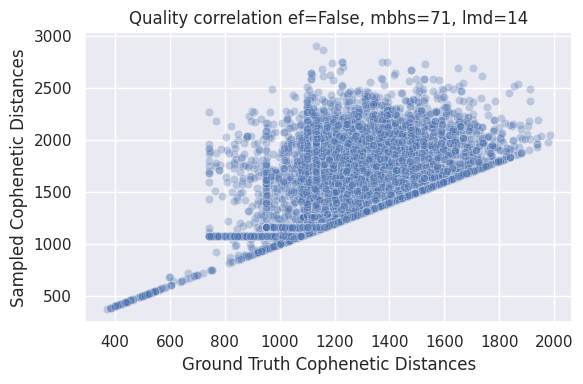

1.1574559611118378
mean_ratio took: 2.1811575889587402s
coph_dist took: 38.31281518936157s


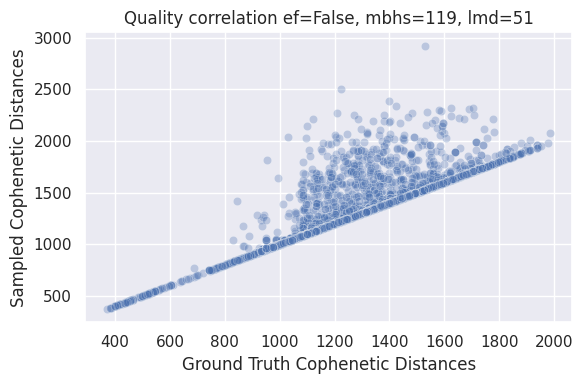

1.0178897326728589
mean_ratio took: 2.0452659130096436s
coph_dist took: 38.499855756759644s


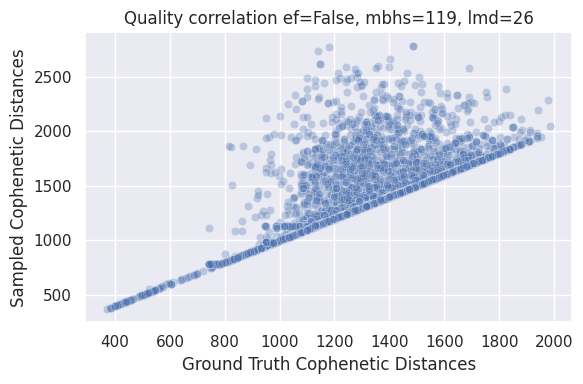

1.0385643073050137
mean_ratio took: 2.067659616470337s
coph_dist took: 38.666576862335205s


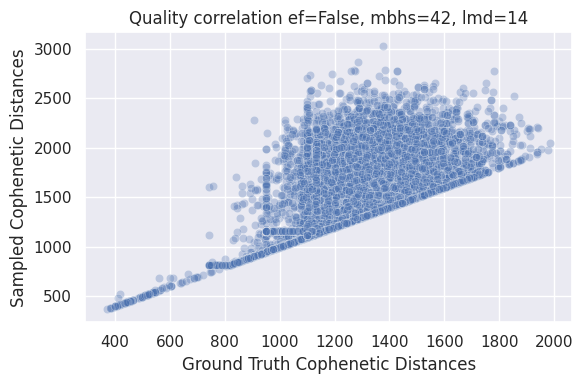

1.169305413267408
mean_ratio took: 2.112150192260742s
coph_dist took: 38.62401580810547s


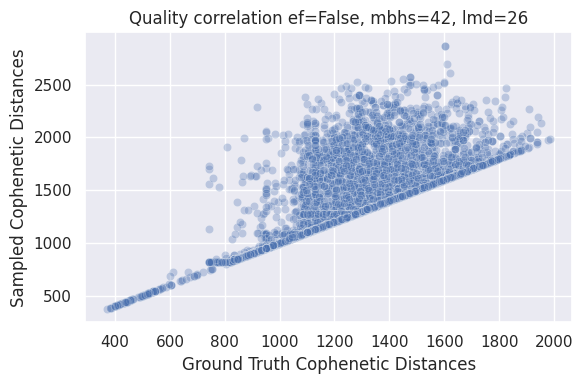

1.0704745728778977
mean_ratio took: 2.0750536918640137s
coph_dist took: 38.91788935661316s


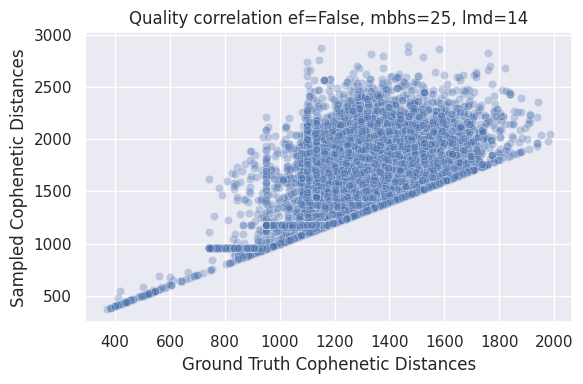

1.1955481270961146
mean_ratio took: 2.0795960426330566s
coph_dist took: 38.371689319610596s


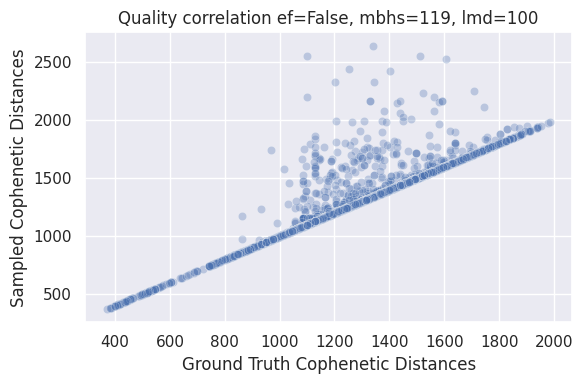

1.006442594026454
mean_ratio took: 2.0571258068084717s
coph_dist took: 38.42290687561035s


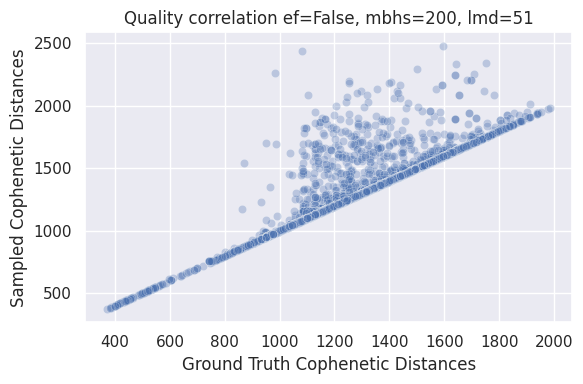

1.0110553702329586
mean_ratio took: 2.0366008281707764s
coph_dist took: 38.428773164749146s
1.0444526347280498
mean_ratio took: 2.0679261684417725s
coph_dist took: 38.46806883811951s
1.0173130794200596
mean_ratio took: 2.042076826095581s
coph_dist took: 38.30542778968811s
1.0014896352941762
mean_ratio took: 2.0517616271972656s
coph_dist took: 38.28556180000305s
1.001632388585203
mean_ratio took: 2.0304739475250244s
coph_dist took: 38.328352212905884s
1.0040228419637385
mean_ratio took: 2.0595009326934814s
coph_dist took: 38.577431440353394s
1.0692816863966108
mean_ratio took: 2.0630548000335693s
coph_dist took: 38.44950008392334s
1.0247807821504877
mean_ratio took: 2.061145782470703s
coph_dist took: 38.55245852470398s
1.0036149522707392
mean_ratio took: 2.036963701248169s
coph_dist took: 38.351120948791504s
1.0059166728926519
mean_ratio took: 2.0595176219940186s
coph_dist took: 38.30264854431152s
1.0071381804417536
mean_ratio took: 2.033849000930786s
0


algo      time      n  \
0  HNSWmst  1.840610  70000   
1  HNSWmst  2.985336  70000   
2  HNSWmst  1.681333  70000   
3  HNSWmst  4.734183  70000   
4  HNSWmst  3.143082  70000   

                                              params  mean_ratio  
0  {"minPts": 1, "symmetric_expand": false, "para...    1.080088  
1  {"minPts": 1, "symmetric_expand": false, "para...    1.062887  
2  {"minPts": 1, "symmetric_expand": false, "para...    1.157456  
3  {"minPts": 1, "symmetric_expand": false, "para...    1.017890  
4  {"minPts": 1, "symmetric_expand": false, "para...    1.038564

In [ ]:
## -- mnist-mst -- ##
import time
import itertools

se = [False]
mbhs = [25, 42, 71, 119, 200]
lmd = [14, 26, 51, 100]

# Generate all combinations
combinations = list(itertools.product(se, mbhs, lmd))

data = []


temp = 0
error = 0
for f in load_all_results(dataset, ""):
    if f.attrs['algo'] != "HNSWmst": continue
    params = json.loads(f.attrs["params"])
    
    if (params['symmetric_expand'],
        params['params']['max_build_heap_size'], 
        params['params']['lowest_max_degree']) not in combinations: continue
    try:
        dendro = [[int(l), int(r), float(d), int(s)] for l, r, d, s in f["dendrogram"][:]]
        dendro = elki_sort_dendrogram(dendro)

        try:
            start = time.time()
            coph_dists = cophenet(dendro)
            end = time.time()
            t = end - start
            print(f"coph_dist took: {t}s")
        except:
            print("ERROR in cophenet")
            error_count += 1

        sampled_gt_coph_dists = gt_coph_dists[indices]
        sampled_coph_dists = np.sqrt(coph_dists[indices])

        mask1 = sampled_gt_coph_dists != 0
        sampled_gt_coph_dists = sampled_gt_coph_dists[mask1]
        sampled_coph_dists = sampled_coph_dists[mask1]
        mask2 = sampled_coph_dists != 0
        sampled_gt_coph_dists = sampled_gt_coph_dists[mask2]
        sampled_coph_dists = sampled_coph_dists[mask2]

        temp += 1
        if temp <= 10:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=sampled_gt_coph_dists[0:10000], y=sampled_coph_dists[0:10000], alpha=0.3)
            plt.title(f"Quality correlation ef={params['symmetric_expand']}, mbhs={params['params']['max_build_heap_size']}, lmd={params['params']['lowest_max_degree']}")
            plt.xlabel("Ground Truth Cophenetic Distances")
            plt.ylabel("Sampled Cophenetic Distances")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        start = time.time()
        ratio = [x / y for x, y in zip(sampled_coph_dists, sampled_gt_coph_dists)]
        mean_ratio = np.exp(np.mean(np.abs(np.log(ratio))))
        print(mean_ratio)
        end = time.time()
        t = end - start
        print(f"mean_ratio took: {t}s")

        data.append({
        "algo": f.attrs['algo'],
        "time": f.attrs['time'],
        "n": len(f["dendrogram"][:]) + 1,
        "params": f.attrs["params"],
        "mean_ratio": mean_ratio,
        })
    finally:
        f.close()

print(error_count)
df_MNISTmst = pd.DataFrame(data=data)
df_MNISTmst.head(5)

In [38]:
df_MNISTmst_split = df_MNISTmst
df_MNISTmst_split["params_dict"] = df_MNISTmst_split["params"].apply(lambda x: json.loads(x))
df_ef = df_MNISTmst_split["params_dict"].apply(lambda d: d.get("symmetric_expand")).rename("symmetric_expand").to_frame()
df_params = df_MNISTmst_split["params_dict"].apply(lambda d: d.get("params", {})).apply(pd.Series)
df_MNISTmst_split = pd.concat([df_MNISTmst_split, df_ef[['symmetric_expand']], df_params[["lowest_max_degree", "max_build_heap_size"]]], axis=1)

df_MNISTmst_split

algo      time      n  \
0   HNSWmst  1.840610  70000   
1   HNSWmst  2.985336  70000   
2   HNSWmst  1.681333  70000   
3   HNSWmst  4.734183  70000   
4   HNSWmst  3.143082  70000   
5   HNSWmst  1.290381  70000   
6   HNSWmst  2.108674  70000   
7   HNSWmst  1.099854  70000   
8   HNSWmst  7.304697  70000   
9   HNSWmst  6.050233  70000   
10  HNSWmst  2.581286  70000   
11  HNSWmst  3.806858  70000   
12  HNSWmst  4.423545  70000   
13  HNSWmst  6.184672  70000   
14  HNSWmst  8.978653  70000   
15  HNSWmst  2.254181  70000   
16  HNSWmst  4.120671  70000   
17  HNSWmst  2.781672  70000   
18  HNSWmst  2.438128  70000   
19  HNSWmst  3.261788  70000   

                                               params  mean_ratio  \
0   {"minPts": 1, "symmetric_expand": false, "para...    1.080088   
1   {"minPts": 1, "symmetric_expand": false, "para...    1.062887   
2   {"minPts": 1, "symmetric_expand": false, "para...    1.157456   
3   {"minPts": 1, "symmetric_expand": false, "para...    1.017890   
4   {"minPts": 1, "symmetric_expand": false, "para...    1.038564   
5   {"minPts": 1, "symmetric_expand": false, "para...    1.169305   
6   {"minPts": 1, "symmetric_expand": false, "para...    1.070475   
7   {"minPts": 1, "symmetric_expand": false, "para...    1.195548   
8   {"minPts": 1, "symmetric_expand": false, "para...    1.006443   
9   {"minPts": 1, "symmetric_expand": false, "para...    1.011055   
10  {"minPts": 1, "symmetric_expand": false, "para...    1.044453   
11  {"minPts": 1, "symmetric_expand": false, "para...    1.017313   
12  {"minPts": 1, "symmetric_expand": false, "para...    1.001490   
13  {"minPts": 1, "symmetric_expand": false, "para...    1.001632   
14  {"minPts": 1, "symmetric_expand": false, "para...    1.004023   
15  {"minPts": 1, "symmetric_expand": false, "para...    1.069282   
16  {"minPts": 1, "symmetric_expand": false, "para...    1.024781   
17  {"minPts": 1, "symmetric_expand": false, "para...    1.003615   
18  {"minPts": 1, "symmetric_expand": false, "para...    1.005917   
19  {"minPts": 1, "symmetric_expand": false, "para...    1.007138   

                                          params_dict  symmetric_expand  \
0   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
1   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
2   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
3   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
4   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
5   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
6   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
7   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
8   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
9   {'minPts': 1, 'symmetric_expand': False, 'para...             False   
10  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
11  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
12  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
13  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
14  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
15  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
16  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
17  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
18  {'minPts': 1, 'symmetric_expand': False, 'para...             False   
19  {'minPts': 1, 'symmetric_expand': False, 'para...             False   

    lowest_max_degree  max_build_heap_size  
0                  26                   25  
1                  14                  200  
2                  14                   71  
3                  51                  119  
4                  26                  119  
5                  14                 

In [39]:
df_MNISTmst_split.to_csv('MNISTmst_meanRatio.csv', index=False)

In [40]:
df_MNISTmst_split = df_MNISTmst_split[["algo", "time", "mean_ratio", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

pareto_mnistmst = get_pareto_frontier(df_MNISTmst_split, "time", "mean_ratio", "algo")

pareto_mnistmst[["time", "mean_ratio", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  mean_ratio  symmetric_expand  max_build_heap_size  \
0  1.099854    1.195548             False                   25   

   lowest_max_degree  
0                 14

In [41]:
filtered_df = pareto_mnistmst[pareto_mnistmst["mean_ratio"] > 0.8]

opt = filtered_df[filtered_df.time == filtered_df.time.min()]

opt[["time", "mean_ratio", "symmetric_expand", "max_build_heap_size", "lowest_max_degree"]]

time  mean_ratio  symmetric_expand  max_build_heap_size  \
0  1.099854    1.195548             False                   25   

   lowest_max_degree  
0                 14

In [42]:
pareto_mnistmst = pareto_mnistmst[["time", "mean_ratio", "max_build_heap_size", "lowest_max_degree"]]

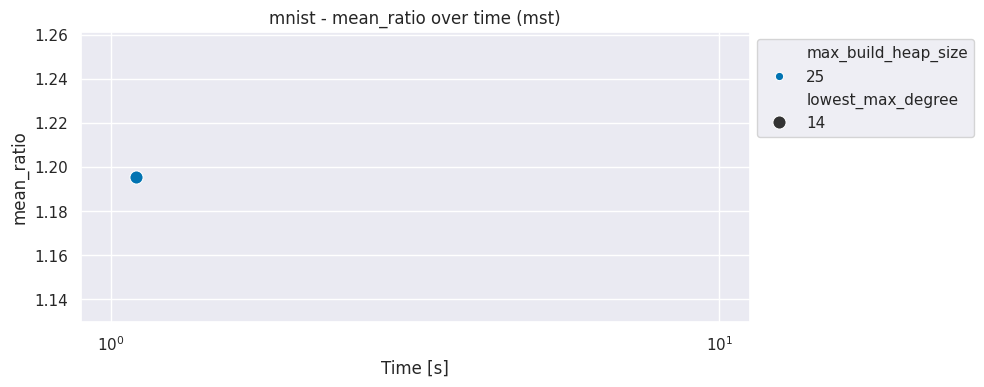

In [43]:
sns.set(style="darkgrid")
ax = plt.figure(figsize=(10, 4))

sns.scatterplot(data=pareto_mnistmst, x="time", y="mean_ratio", 
                hue="max_build_heap_size",
                size="lowest_max_degree",
                palette="colorblind", 
                # markers={True: "X", False: "o"},
                sizes=(90, 500))

plt.title(f"mnist - mean_ratio over time (mst)")
plt.xlabel("Time [s]")
plt.ylabel("mean_ratio")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.xscale("log")

plt.show()

# break

In [44]:
df_ALOIhssl = pd.read_csv("ALOIhssl.csv")
df_ALOIkruskal = pd.read_csv("ALOIkruskal.csv")
df_ALOImst = pd.read_csv("ALOImst.csv")
df_MNISThssl = pd.read_csv("MNISThssl.csv")
df_MNISTkruskal = pd.read_csv("MNISTkruskal.csv")
df_MNISTmst = pd.read_csv("MNISTmst.csv")


In [45]:
import numpy as np

a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

ratio = [x / y for x, y in zip(a, b)]
q = np.exp(np.mean(np.abs(np.log(ratio))))

print(ratio)
q

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


np.float64(2.0)